In [1]:
# https://ipython.org/ipython-doc/3/config/extensions/autoreload.html
%load_ext autoreload
%autoreload 2

# Static inline plots
%matplotlib inline

# Interactive plots
# %matplotlib notebook

# Load all packages used
import matplotlib.pyplot as plt
import numpy as np
import mypackage
import joblib

timer = mypackage.Timer()

TensorFlow version is 2.1.0


Using TensorFlow backend.


In [2]:
# First load the labeled data and train on it
X, Y, info = mypackage.Dataset.load("data/tomra_all", only_with_contaminant=True)

X_train_orig, X_test_orig, Y_train_orig, Y_test_orig = mypackage.Dataset.train_test_split(X, Y, testRatio=0.3)
X_test_orig, X_train_orig, scaler = mypackage.Dataset.scale(X_test_orig, X_train_orig, scaler='GlobalStandardization')

# save the scaler to disk
filename = 'latest_scaler_used.sav'
joblib.dump(scaler, filename)
# # load the scaler from disk
# scaler = joblib.load(filename)

zoom = lambda X, Y, size, mp, noise=True: mypackage.Dataset.make_zoomed_in_dataset(X, Y, size=size, 
                                                             sample_multiplication=mp, contaminant_type=2,
                                                             zoom_with_noise=noise, flip=True)
s, m = 32, 40
X_train, Y_train = zoom(X_train_orig, Y_train_orig, s, m)
X_test,  Y_test  = zoom(X_test_orig,  Y_test_orig,  s, m)

######################################################
# Need extra padding for the HybridSN classification
window_size = 25
margin = int((window_size - 1) / 2)
padding = margin * 2
size = 32 + padding

s, m = size, 1
X_train_HS, Y_train_HS = zoom(X_train_orig, Y_train_orig, s, m, noise=False)
X_test_HS,  Y_test_HS  = zoom(X_test_orig,  Y_test_orig,  s, m, noise=False)
#######################################################

print(np.unique(Y_test), Y_test.shape, (X_test.min(), X_test.max()), X_test.shape, X_train.shape)
print(np.unique(Y_train, return_counts=True))
print(np.unique(Y_test, return_counts=True))
# print(np.unique(Y_train_HS, return_counts=True))
# print(np.unique(Y_test_HS, return_counts=True))

# Test HybridSN

In [ ]:
n_train = 16 # if 16 then 30min per epoch
n_test  = 4
model = mypackage.HybridSN(X_train_HS, Y_train_HS, X_test_HS, Y_test_HS)
model.summary()

timer.start()
model.train(epochs=5)
timer.stop()

model.plot_training_results()
model.predict(X_train_HS, Y_train_HS)
timer.start()
model.predict(X_test_HS, Y_test_HS)
timer.stop()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 25, 25, 208, 1)    0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 23, 23, 68, 8)     512       
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 21, 21, 22, 16)    5776      
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 19, 19, 7, 32)     13856     
_________________________________________________________________
reshape_1 (Reshape)          (None, 19, 19, 224)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 17, 17, 64)        129088    
_________________________________________________________________
flatten_1 (Flatten)          (None, 18496)             0   

# Testing SVM

In [ ]:
# Started the training at ~16:30
# Finished training at ~17:00

Start training
Elapsed time: 4931.5477 seconds
Training data prediction
              precision    recall  f1-score   support

         0.0       0.98      0.96      0.97     92600
         1.0       0.94      0.99      0.96    211543
         2.0       0.94      0.68      0.79     31729

    accuracy                           0.95    335872
   macro avg       0.95      0.87      0.90    335872
weighted avg       0.95      0.95      0.95    335872

Test data prediction
Elapsed time: 1783.6231 seconds
              precision    recall  f1-score   support

         0.0       0.97      0.95      0.96     32410
         1.0       0.94      0.99      0.96     98030
         2.0       0.94      0.69      0.80     13944

    accuracy                           0.95    144384
   macro avg       0.95      0.88      0.91    144384
weighted avg       0.95      0.95      0.95    144384



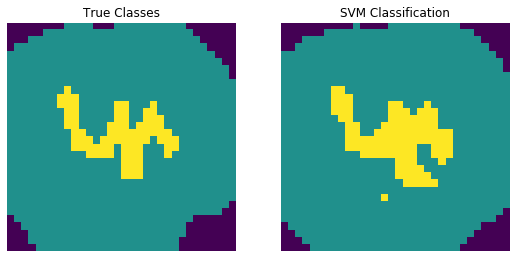

In [3]:
from sklearn import svm
from sklearn.metrics import classification_report

train = mypackage.StackTransform(X_train, Y_train)
test = mypackage.StackTransform(X_test, Y_test)

svc_classifier = svm.SVC(C=1, kernel='rbf', decision_function_shape='ovr')
print("Start training")
timer.start()
svc_classifier.fit(train.X_stack(), train.Y_stack().ravel())
timer.stop()

# save the model to disk
filename = 'latest_svm_model.sav'
joblib.dump(svc_classifier, filename)

# # load the model from disk
# svc_classifier = joblib.load(filename)
Y_hat = svc_classifier.predict(train.X_stack())
classification = classification_report(train.Y_stack(), Y_hat) # .flatten()
print("Training data prediction")
print(classification)
print("Test data prediction")
timer.start()
Y_hat = svc_classifier.predict(test.X_stack())
timer.stop()
classification = classification_report(test.Y_stack(), Y_hat) # .flatten()
print(classification)

Y_hat = test.Unstack(Y_hat, k=1)

import matplotlib.pyplot as plt
plt.figure(figsize=(9, 5))
plt.subplot(1, 2, 1)
plt.title("True Classes")
plt.imshow(np.squeeze(Y_test[0]))
plt.axis('off')
plt.subplot(1, 2, 2)
plt.title("SVM Classification")
plt.imshow(np.squeeze(Y_hat[0]))
plt.axis('off');

# Testing Logistic Regression

Start training
Elapsed time: 36.4686 seconds
Training data prediction
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1108
         1.0       1.00      1.00      1.00      3719
         2.0       1.00      1.00      1.00       293

    accuracy                           1.00      5120
   macro avg       1.00      1.00      1.00      5120
weighted avg       1.00      1.00      1.00      5120

Test data prediction
Elapsed time: 0.0044 seconds
              precision    recall  f1-score   support

         0.0       0.94      0.86      0.90       734
         1.0       0.93      0.98      0.96      3855
         2.0       0.86      0.61      0.71       531

    accuracy                           0.93      5120
   macro avg       0.91      0.82      0.86      5120
weighted avg       0.93      0.93      0.92      5120



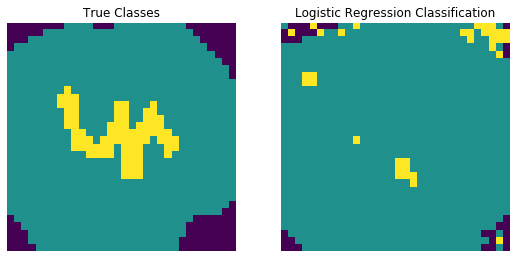

In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

train = mypackage.StackTransform(X_train[:5], Y_train[:5])
test = mypackage.StackTransform(X_test[:5], Y_test[:5])

logreg = LogisticRegression(C=1e5, max_iter=50000)
print("Start training")
timer.start()
logreg.fit(train.X_stack(), train.Y_stack().ravel())
timer.stop()

# save the model to disk
filename = 'latest_LogisticReg_model.sav'
joblib.dump(logreg, filename)

# # load the model from disk
# logreg = joblib.load(filename)
Y_hat = logreg.predict(train.X_stack())
classification = classification_report(train.Y_stack(), Y_hat) # .flatten()
print("Training data prediction")
print(classification)
print("Test data prediction")
timer.start()
Y_hat = logreg.predict(test.X_stack())
timer.stop()
classification = classification_report(test.Y_stack(), Y_hat) # .flatten()
print(classification)

Y_hat = test.Unstack(Y_hat, k=1)

import matplotlib.pyplot as plt
plt.figure(figsize=(9, 5))
plt.subplot(1, 2, 1)
plt.title("True Classes")
plt.imshow(np.squeeze(Y_test[0]))
plt.axis('off')
plt.subplot(1, 2, 2)
plt.title("Logistic Regression Classification")
plt.imshow(np.squeeze(Y_hat[0]))
plt.axis('off');

### Test SpectralUNet on the same data

Start training
X_input (328, 32, 32, 208, 1), Y_input (328, 32, 32, 3)
Train on 295 samples, validate on 33 samples
Epoch 1/60
290/295 [============================>.] - ETA: 0s - loss: 0.6947 - accuracy: 0.8189
Epoch 00001: val_loss improved from inf to 0.81367, saving model to best-model.hdf5
295/295 [==============================] - 17s 59ms/sample - loss: 0.6912 - accuracy: 0.8204 - val_loss: 0.8137 - val_accuracy: 0.8721
Epoch 2/60
290/295 [============================>.] - ETA: 0s - loss: 0.4275 - accuracy: 0.9093
Epoch 00002: val_loss improved from 0.81367 to 0.72828, saving model to best-model.hdf5
295/295 [==============================] - 15s 52ms/sample - loss: 0.4254 - accuracy: 0.9096 - val_loss: 0.7283 - val_accuracy: 0.7931
Epoch 3/60
290/295 [============================>.] - ETA: 0s - loss: 0.3045 - accuracy: 0.9275
Epoch 00003: val_loss improved from 0.72828 to 0.57616, saving model to best-model.hdf5
295/295 [==============================] - 15s 52ms/sample - loss:

Epoch 28/60
290/295 [============================>.] - ETA: 0s - loss: 0.0809 - accuracy: 0.9704
Epoch 00028: val_loss did not improve from 0.11162
295/295 [==============================] - 15s 52ms/sample - loss: 0.0807 - accuracy: 0.9705 - val_loss: 0.1278 - val_accuracy: 0.9565
Epoch 29/60
290/295 [============================>.] - ETA: 0s - loss: 0.0699 - accuracy: 0.9742
Epoch 00029: val_loss improved from 0.11162 to 0.10863, saving model to best-model.hdf5
295/295 [==============================] - 15s 52ms/sample - loss: 0.0702 - accuracy: 0.9741 - val_loss: 0.1086 - val_accuracy: 0.9605
Epoch 30/60
290/295 [============================>.] - ETA: 0s - loss: 0.0699 - accuracy: 0.9742
Epoch 00030: val_loss did not improve from 0.10863
295/295 [==============================] - 15s 52ms/sample - loss: 0.0697 - accuracy: 0.9742 - val_loss: 0.1599 - val_accuracy: 0.9487
Epoch 31/60
290/295 [============================>.] - ETA: 0s - loss: 0.0733 - accuracy: 0.9724
Epoch 00031: val_

Epoch 57/60
290/295 [============================>.] - ETA: 0s - loss: 0.0524 - accuracy: 0.9805
Epoch 00057: val_loss did not improve from 0.10863
295/295 [==============================] - 15s 52ms/sample - loss: 0.0522 - accuracy: 0.9805 - val_loss: 0.1313 - val_accuracy: 0.9576
Epoch 58/60
290/295 [============================>.] - ETA: 0s - loss: 0.0432 - accuracy: 0.9835
Epoch 00058: val_loss did not improve from 0.10863
295/295 [==============================] - 15s 52ms/sample - loss: 0.0432 - accuracy: 0.9835 - val_loss: 0.1250 - val_accuracy: 0.9593
Epoch 59/60
290/295 [============================>.] - ETA: 0s - loss: 0.0423 - accuracy: 0.9838
Epoch 00059: val_loss did not improve from 0.10863
295/295 [==============================] - 15s 52ms/sample - loss: 0.0422 - accuracy: 0.9838 - val_loss: 0.1318 - val_accuracy: 0.9567
Epoch 60/60
290/295 [============================>.] - ETA: 0s - loss: 0.0424 - accuracy: 0.9838
Epoch 00060: val_loss did not improve from 0.10863
295

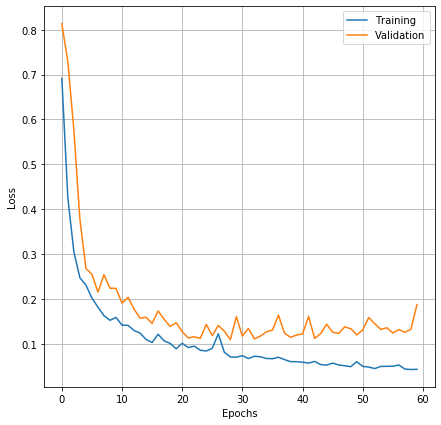

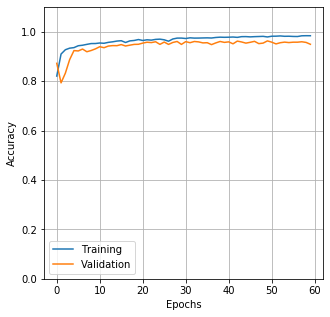

Predicting for train data
Elapsed time: 4.3353 seconds
              precision    recall  f1-score   support

           0       0.98      0.99      0.98     92600
           1       0.98      0.99      0.99    211543
           2       0.94      0.92      0.93     31729

    accuracy                           0.98    335872
   macro avg       0.97      0.96      0.97    335872
weighted avg       0.98      0.98      0.98    335872



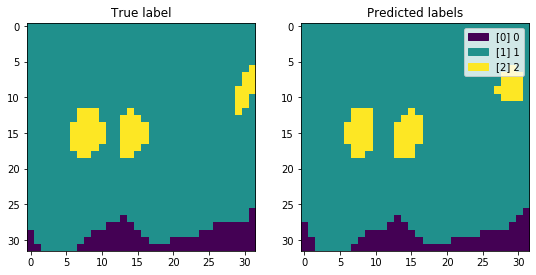

Predicting for test data
Elapsed time: 1.7586 seconds
              precision    recall  f1-score   support

           0       0.97      0.97      0.97     32410
           1       0.97      0.98      0.98     98030
           2       0.90      0.85      0.87     13944

    accuracy                           0.97    144384
   macro avg       0.95      0.93      0.94    144384
weighted avg       0.96      0.97      0.96    144384



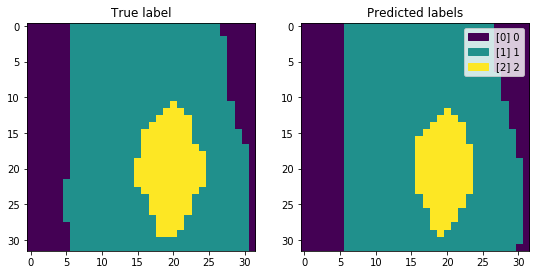

Elapsed time: 2.2145 seconds


In [5]:
spectral_unet = mypackage.SpectralUNet(X_train, Y_train, batchnorm=True, dropout=0.5)
print("Start training")
timer.start()
spectral_unet.train(batch_size=5, epochs=60, validation_split=0.1, clear_output=False, monitor='val_loss', mode='min')
timer.stop()

# spectral_unet.summary()
spectral_unet.plot_training_results()
print("Predicting for train data")
spectral_unet.predict(X_train, Y_labels=Y_train)
print("Predicting for test data")
timer.start()
spectral_unet.predict(X_test, Y_labels=Y_test);
timer.stop()


### Test 2D UNet on the same data

Start training
Elapsed time: 272.7283 seconds


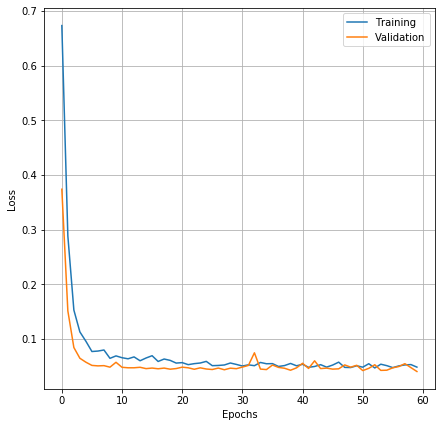

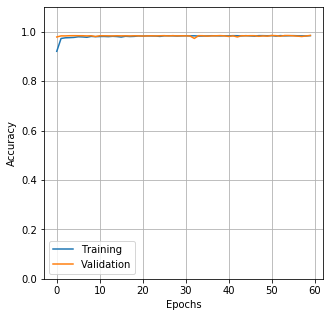

Predicting for train data
Elapsed time: 0.9074 seconds
              precision    recall  f1-score   support

           0       0.99      1.00      0.99   1443451
           1       0.96      0.96      0.96    337611
           2       0.82      0.61      0.70     21178

    accuracy                           0.99   1802240
   macro avg       0.93      0.86      0.89   1802240
weighted avg       0.98      0.99      0.98   1802240



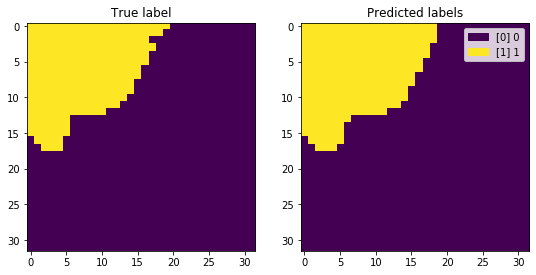

Predicting for test data
Elapsed time: 0.3182 seconds
              precision    recall  f1-score   support

           0       0.99      1.00      0.99    680605
           1       0.95      0.95      0.95    128330
           2       0.86      0.58      0.69     10265

    accuracy                           0.98    819200
   macro avg       0.93      0.84      0.88    819200
weighted avg       0.98      0.98      0.98    819200



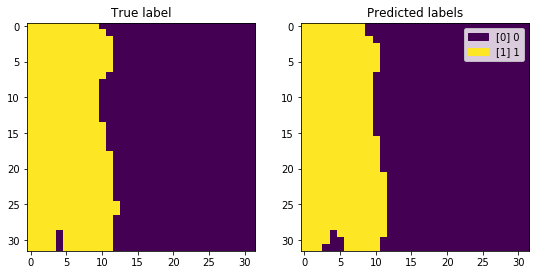

Elapsed time: 1.5552 seconds
Number of layers in the base model:  49


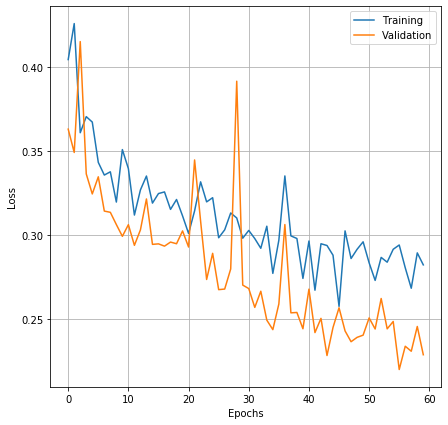

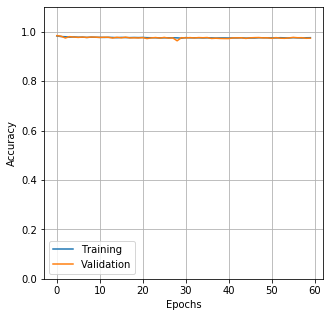

Predicting for test data after Dice_Loss focus on contaminants
Elapsed time: 0.5248 seconds
              precision    recall  f1-score   support

           0       0.98      1.00      0.99    680605
           1       0.97      0.87      0.92    128330
           2       0.84      0.65      0.73     10265

    accuracy                           0.98    819200
   macro avg       0.93      0.84      0.88    819200
weighted avg       0.97      0.98      0.97    819200



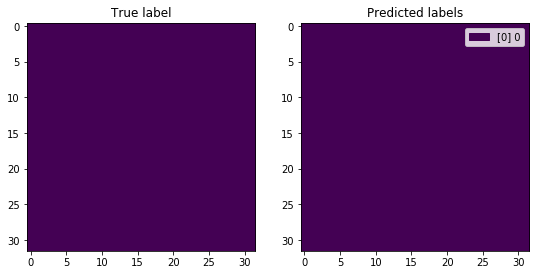

In [7]:
# I would like to use as input these channels
# 7: 953nm, 40: 1072, 68: 1173nm, 138: 1426nm, -1: 1674nm -> 1173nm, 1426nm, 1674nm match to the expected based on labratory measurements
channels_used = [7, 40, 68, 138, -1]
unet = mypackage.UNet(X_train[..., channels_used], Y_train, batchnorm=True, dropout=0.5)
print("Start training")
timer.start()
unet.train(batch_size=5, epochs=60, validation_split=0.1, clear_output=False, monitor='val_loss', mode='min', verbose=0)
timer.stop()

# unet.summary()
unet.plot_training_results()
print("Predicting for train data")
unet.predict(X_train[..., channels_used], Y_labels=Y_train)
print("Predicting for test data")
timer.start()
unet.predict(X_test[..., channels_used], Y_labels=Y_test);
timer.stop()

tl = lambda y_true, y_pred: mypackage.lf.tversky_loss(y_true, y_pred, only_contaminant=True)
unet.retrain(X_train[..., channels_used], Y_train, batch_size=20, epochs=60, loss=tl, validation_split=0.1, verbose=0)
unet.plot_training_results()
print("Predicting for test data after Dice_Loss focus on contaminants")
y_pred_test, y_pred_heat = unet.predict(X_test[..., channels_used], Y_labels=Y_test, return_heat_map=True);

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



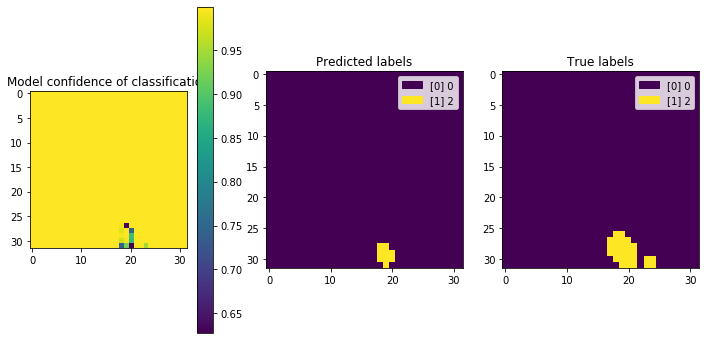

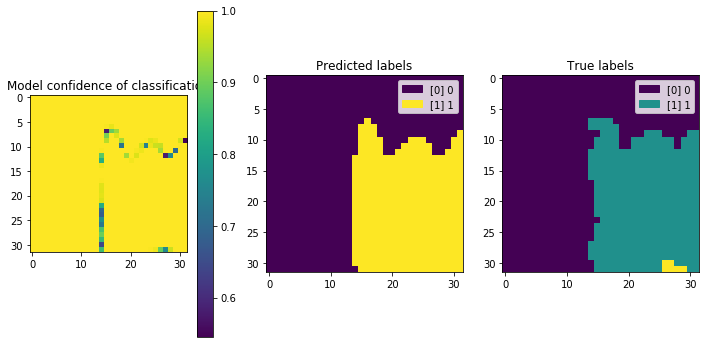

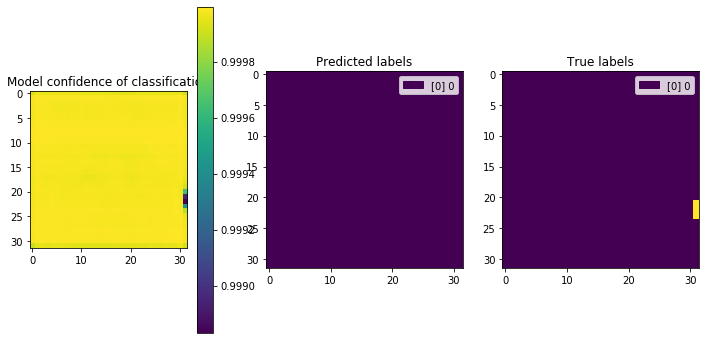

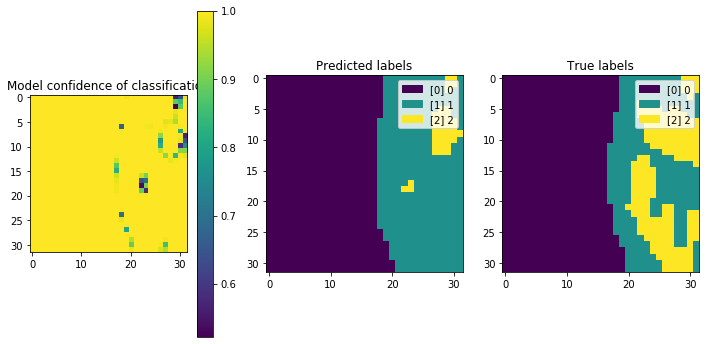

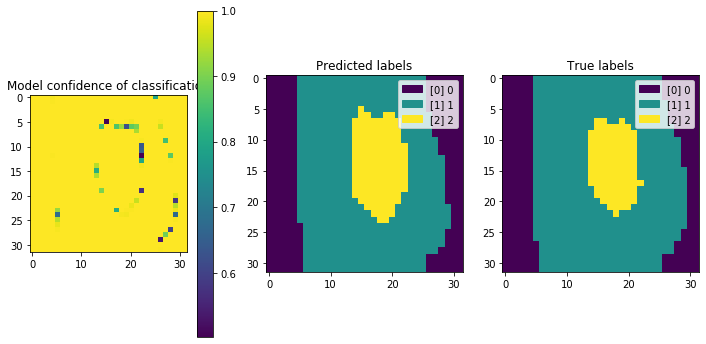

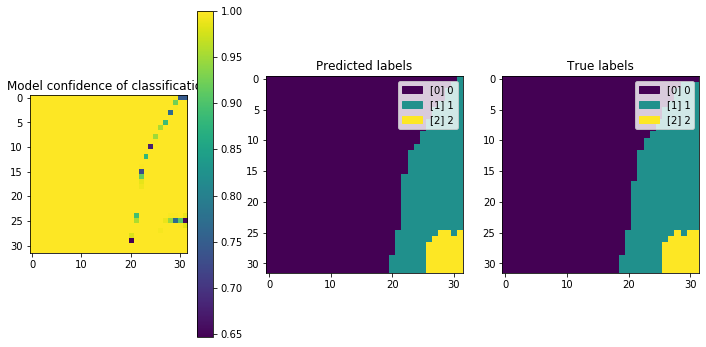

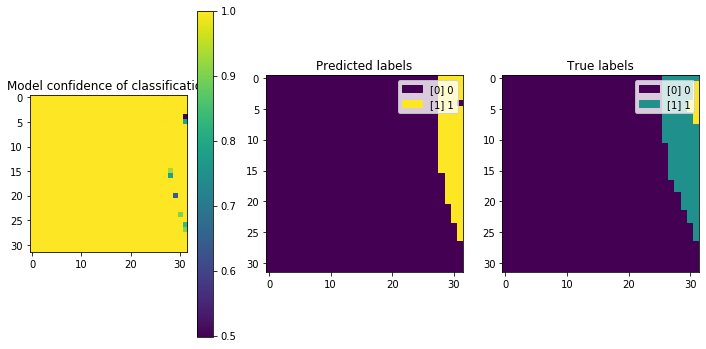

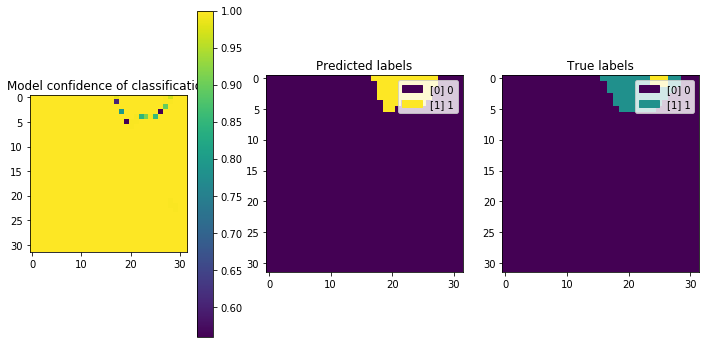

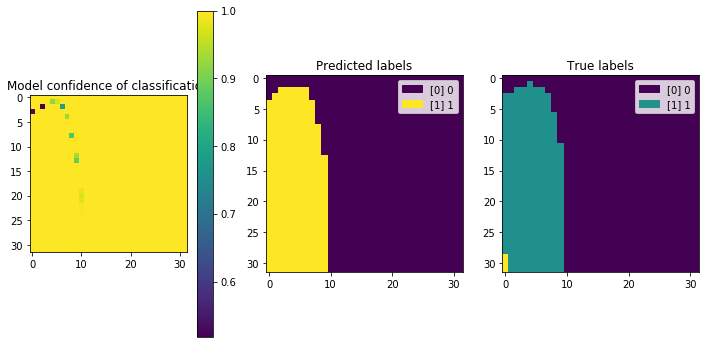

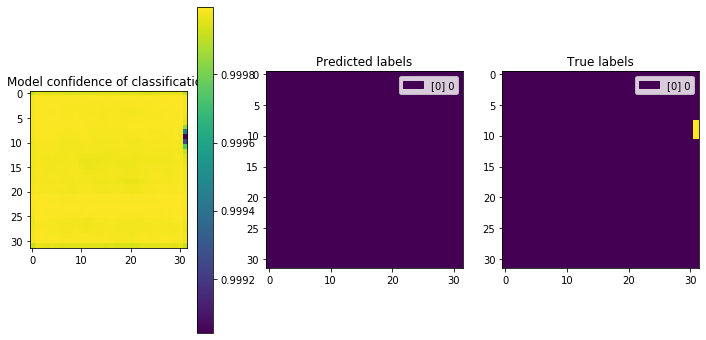

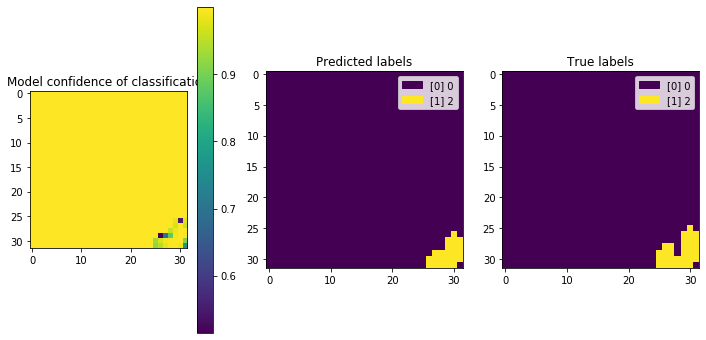

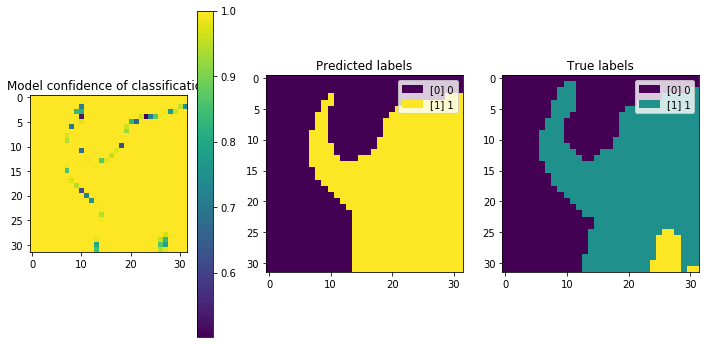

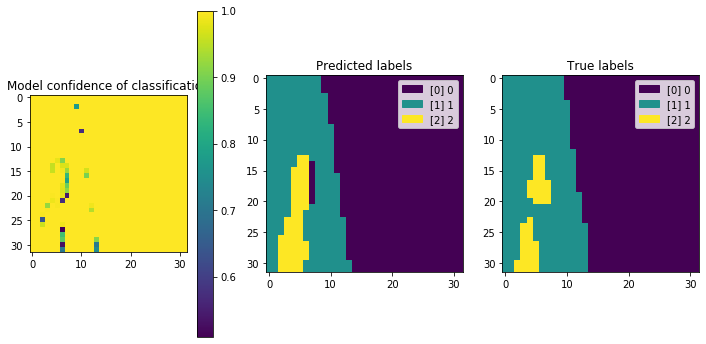

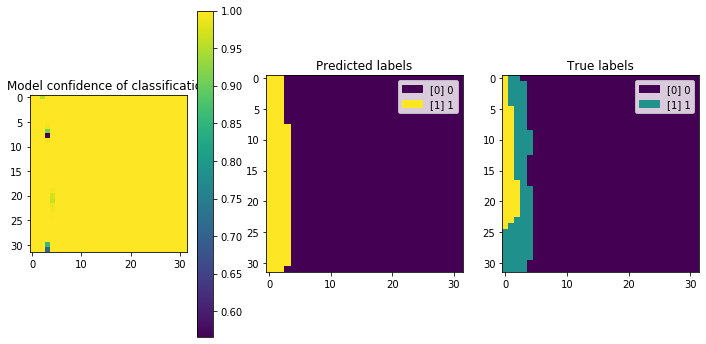

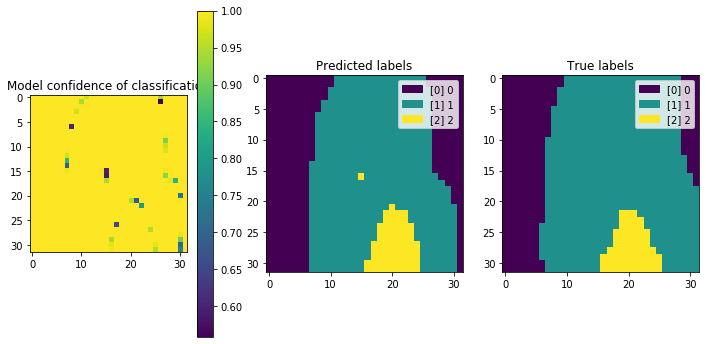

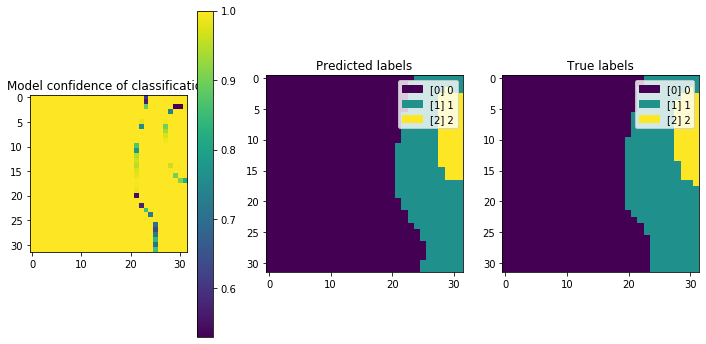

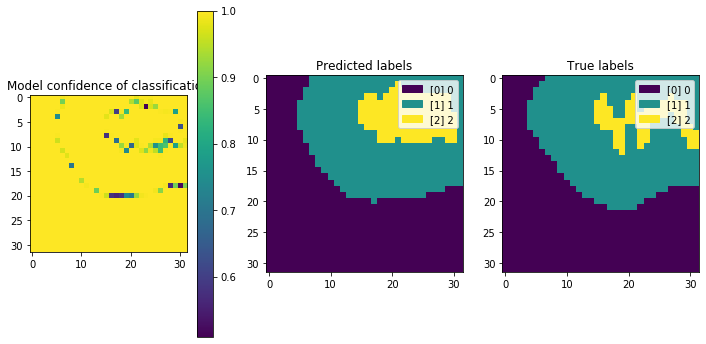

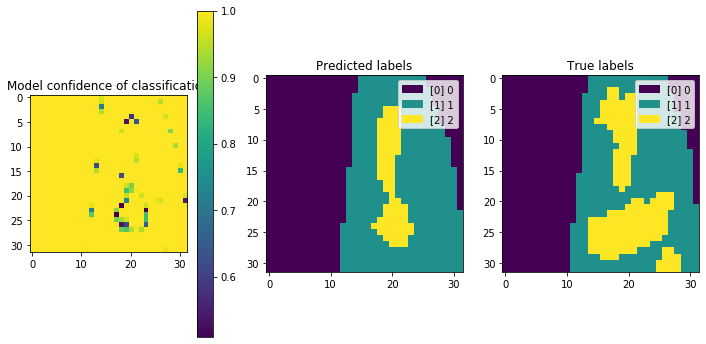

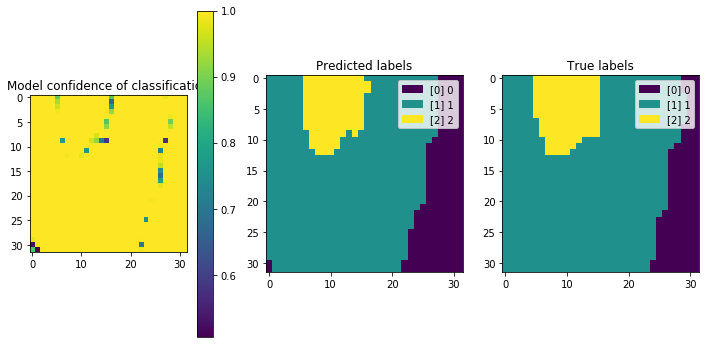

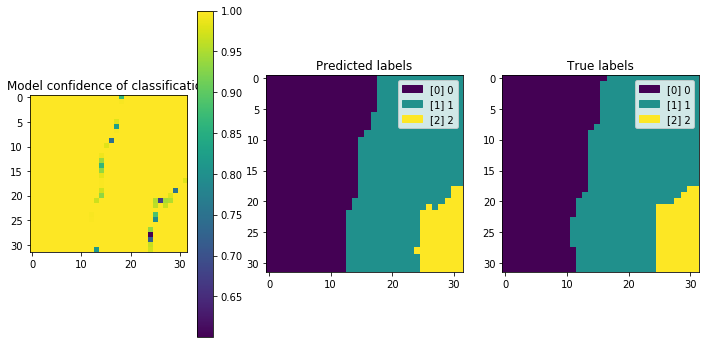

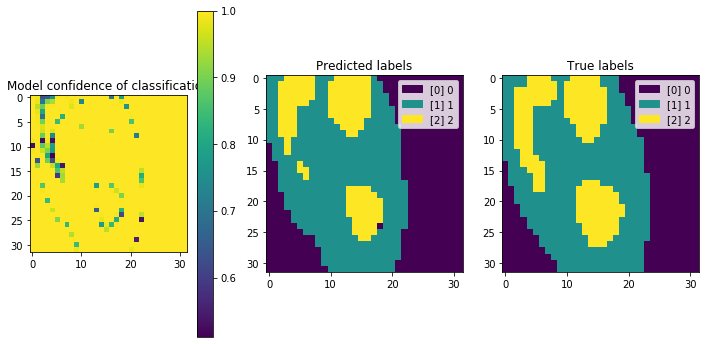

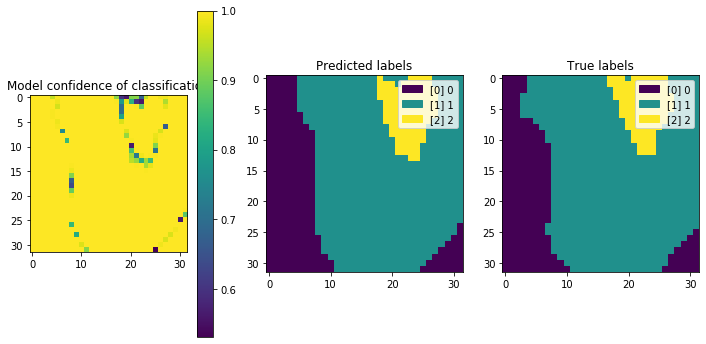

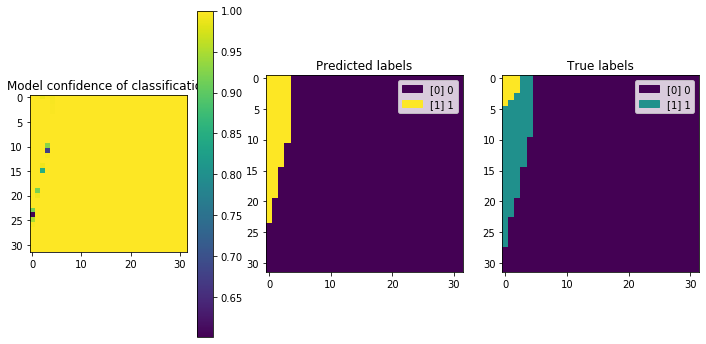

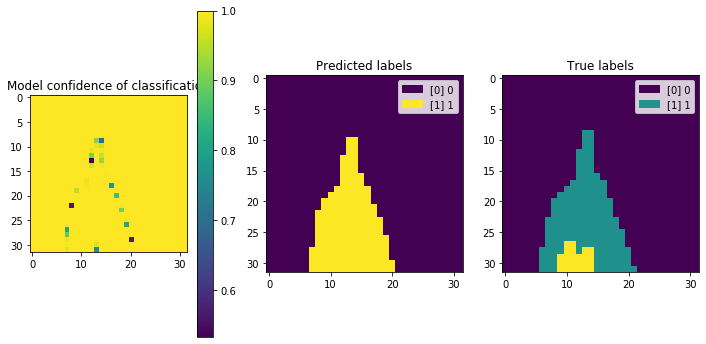

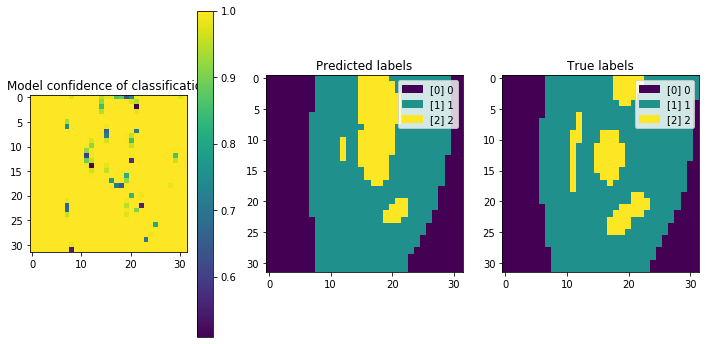

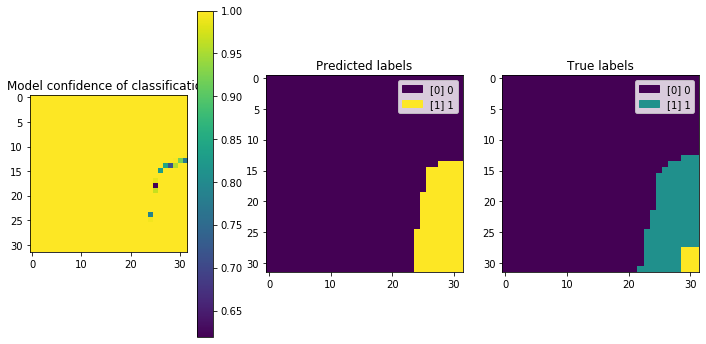

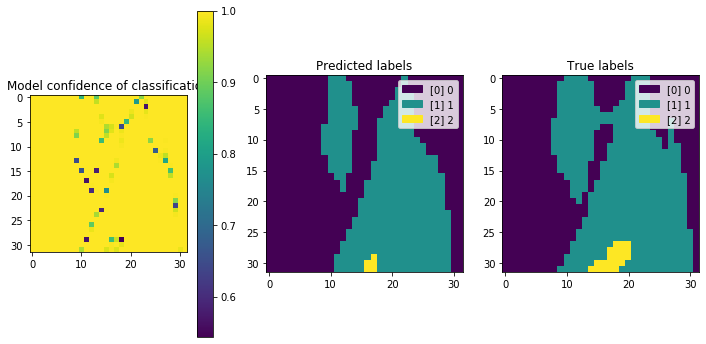

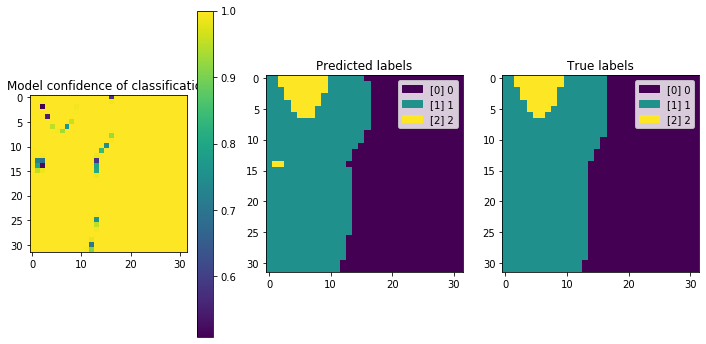

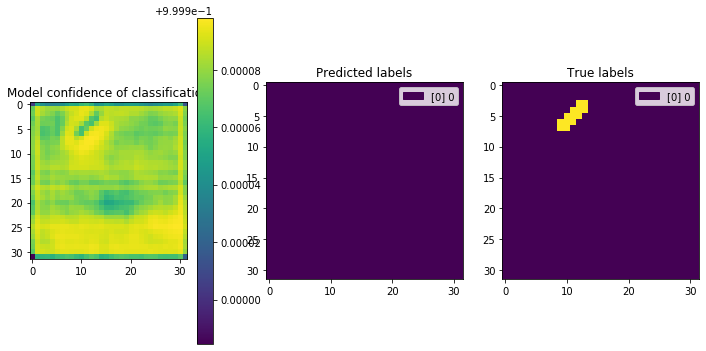

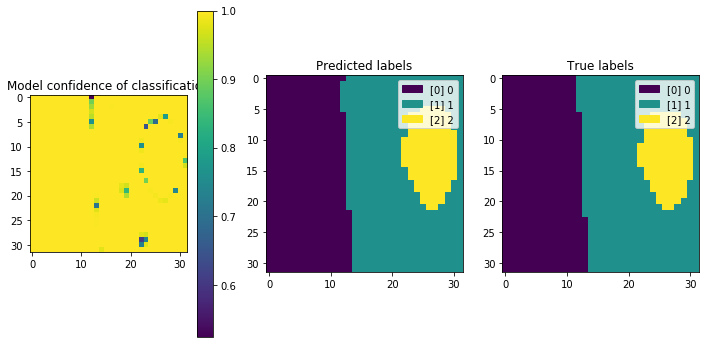

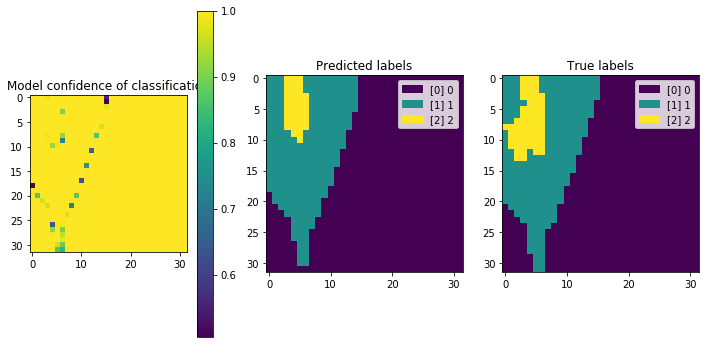

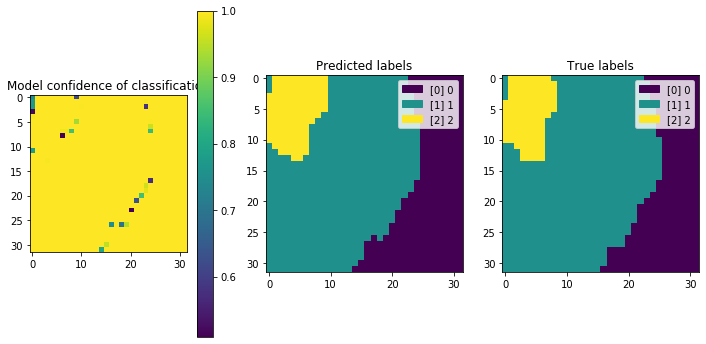

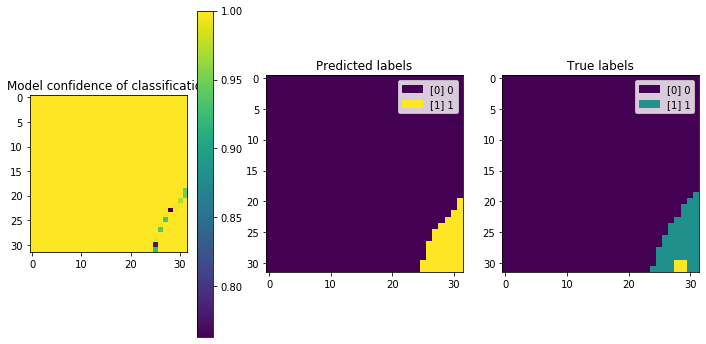

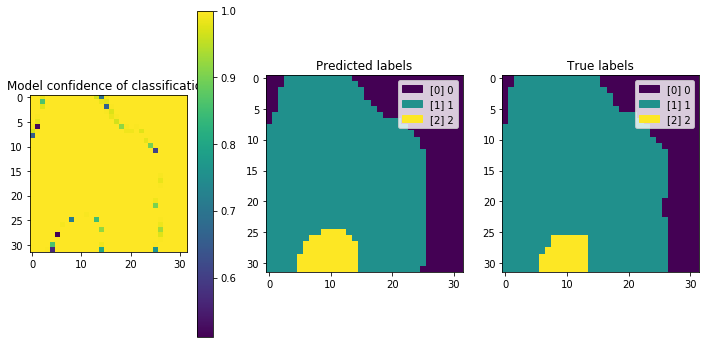

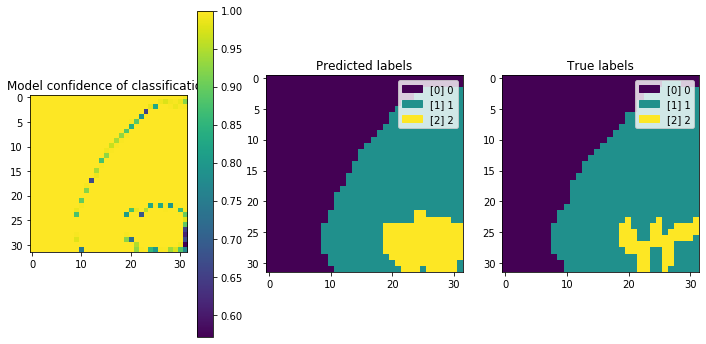

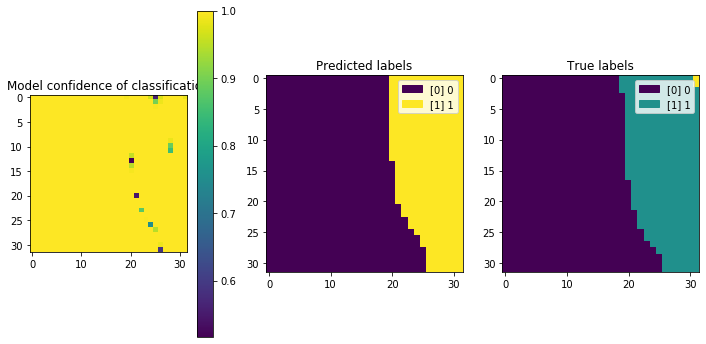

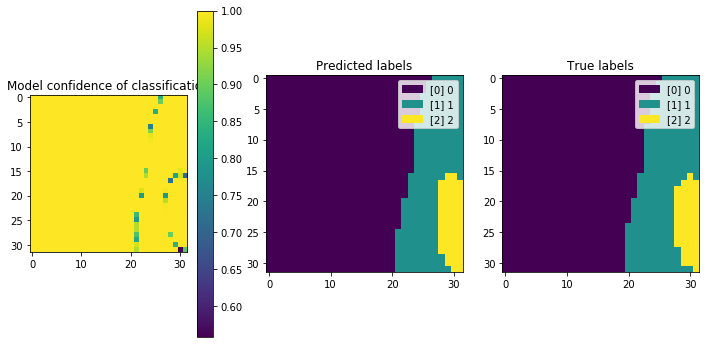

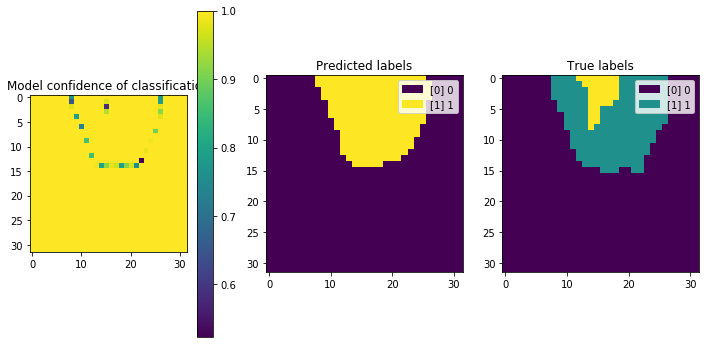

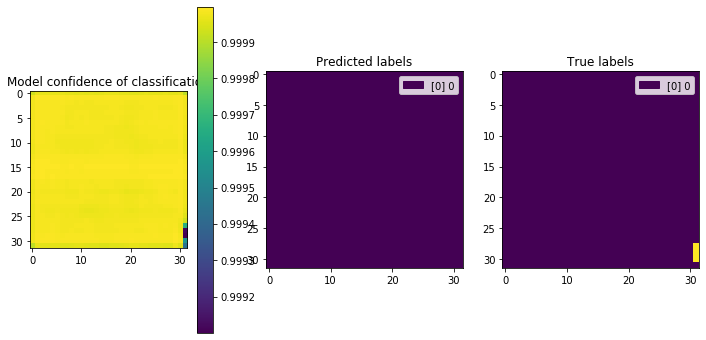

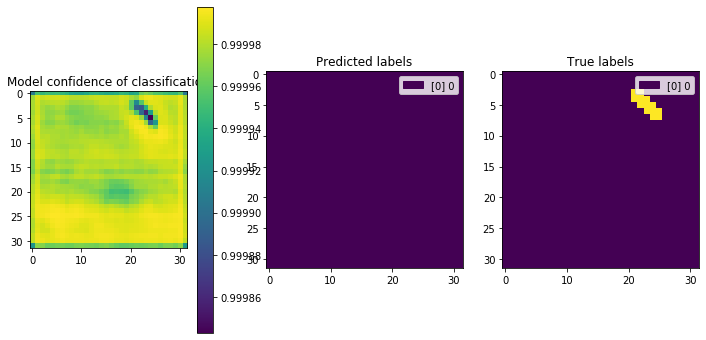

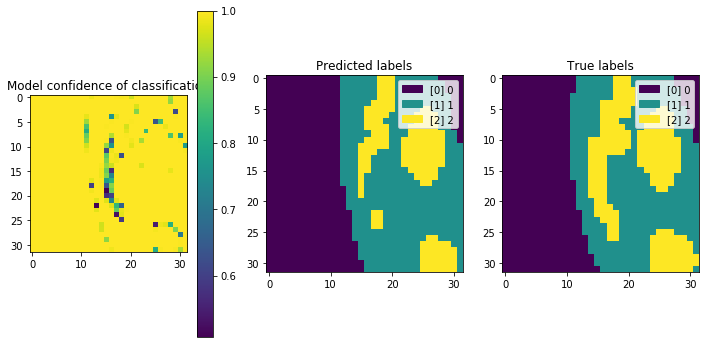

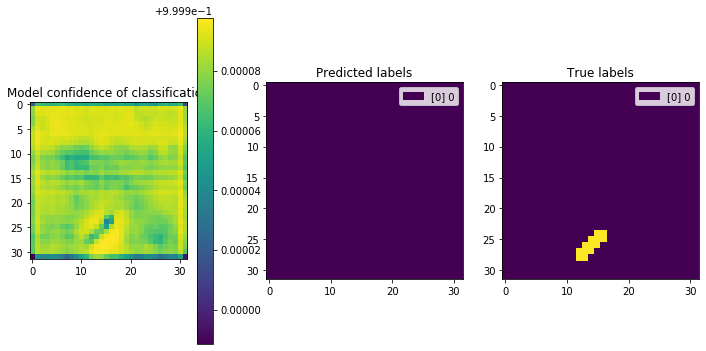

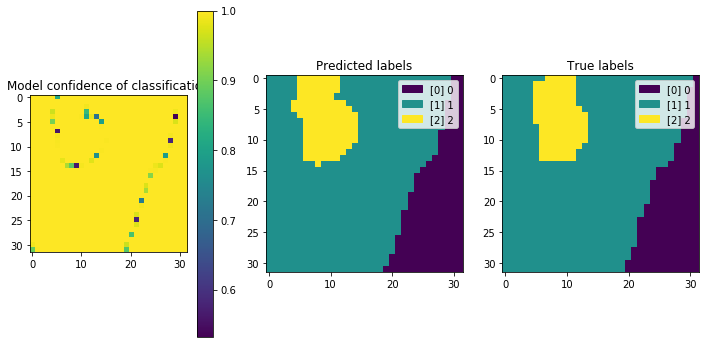

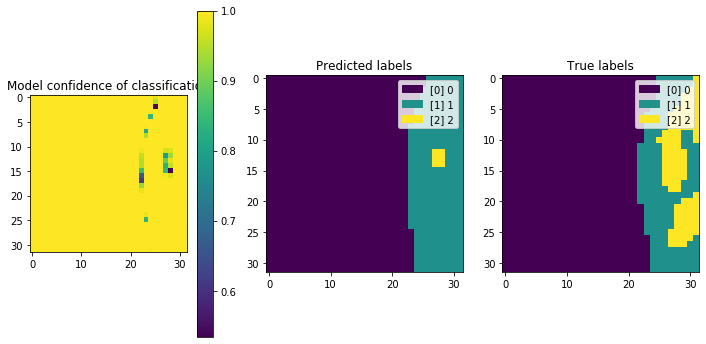

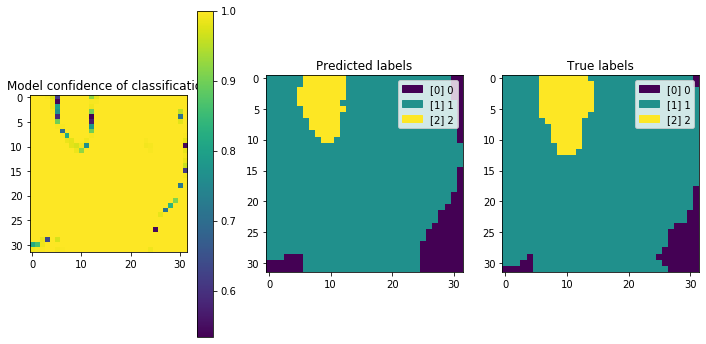

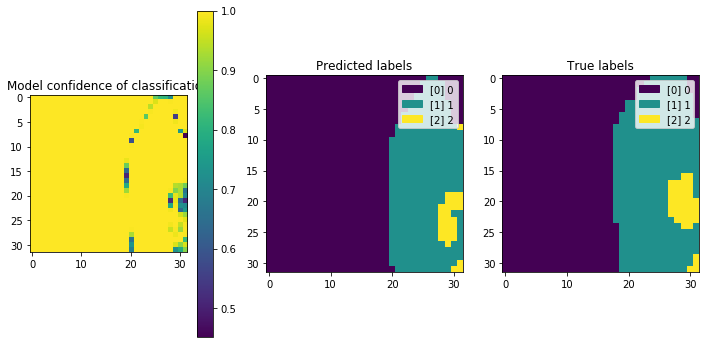

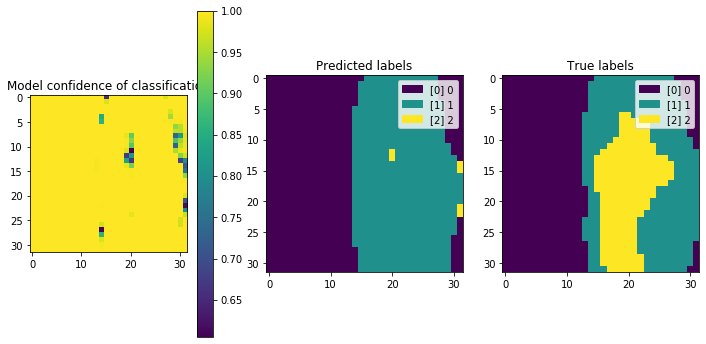

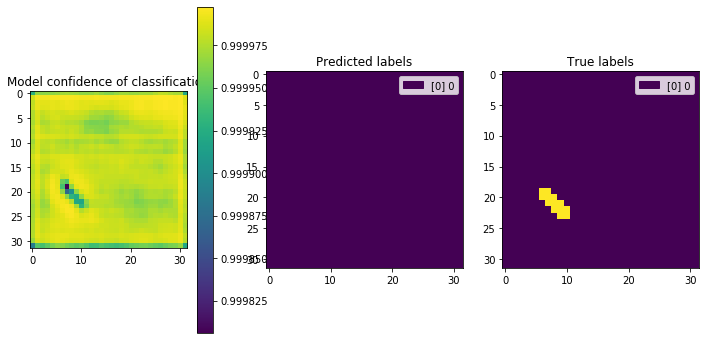

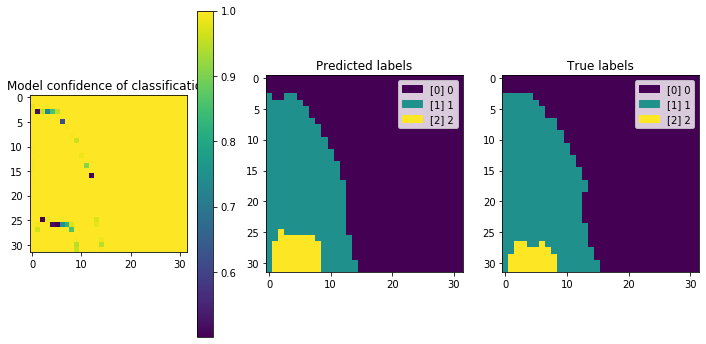

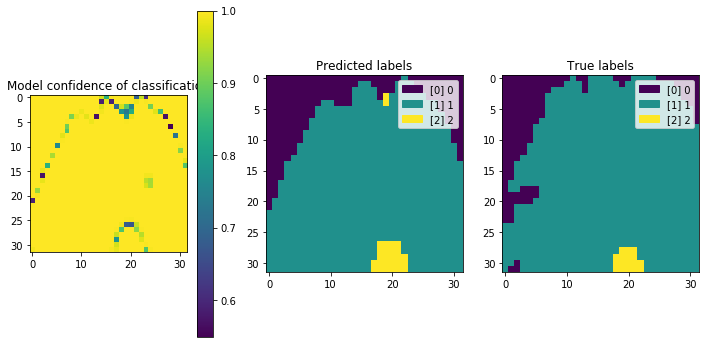

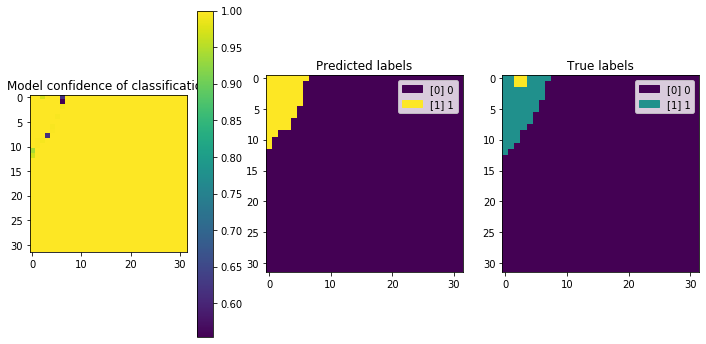

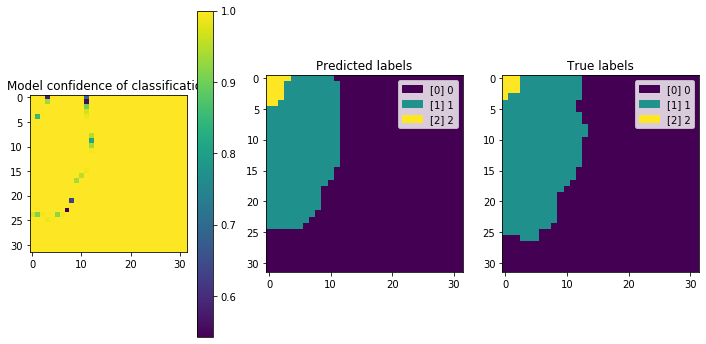

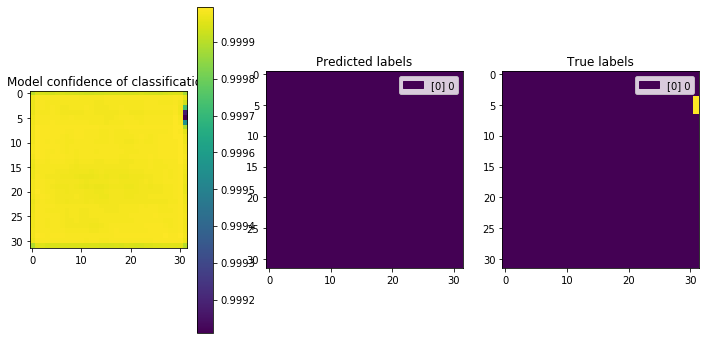

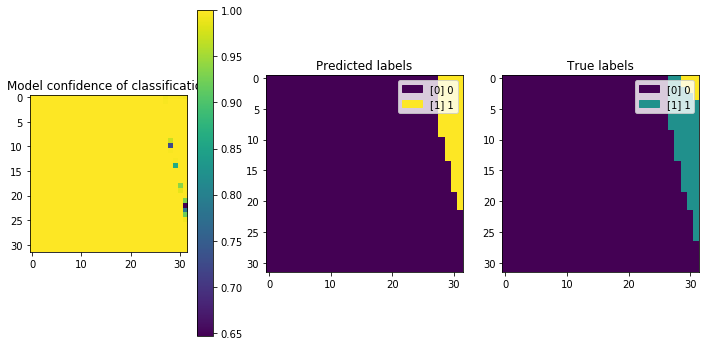

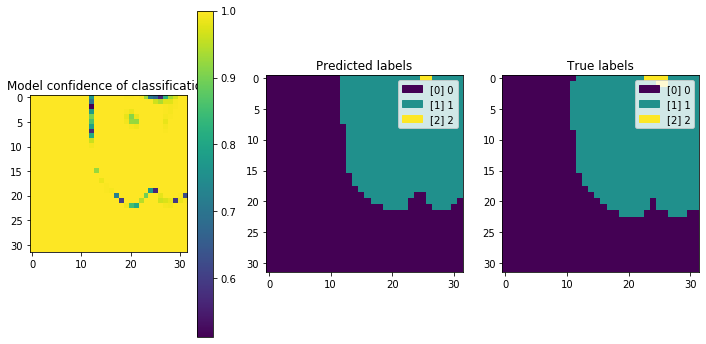

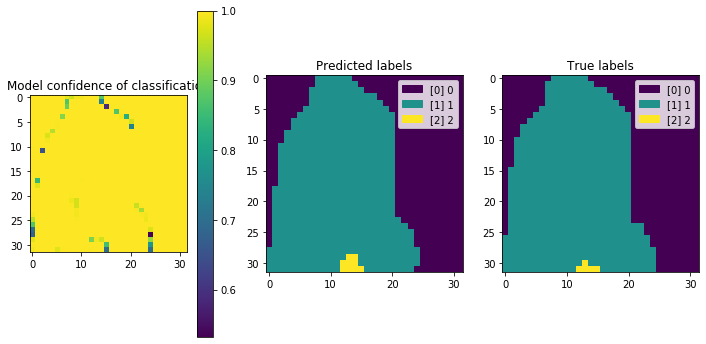

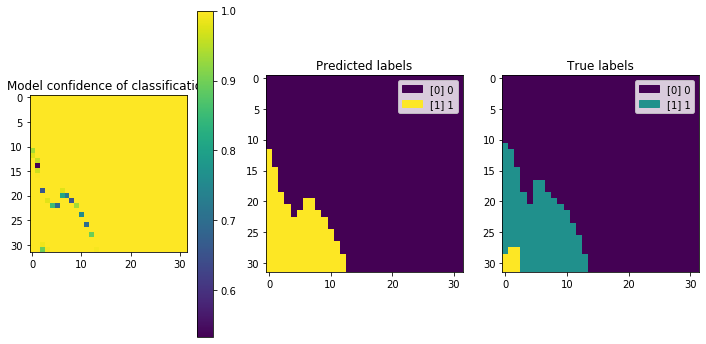

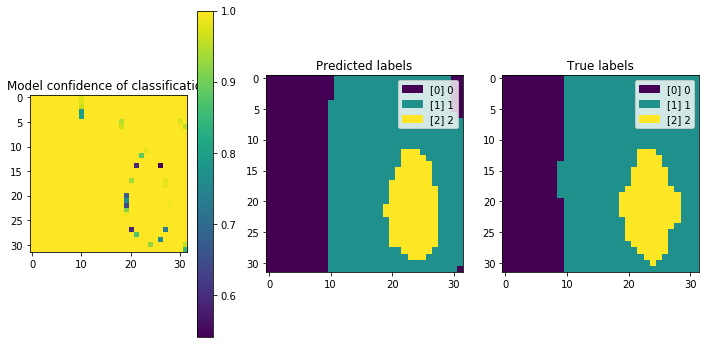

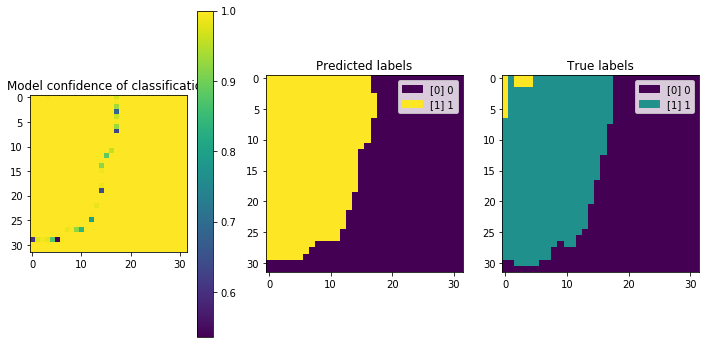

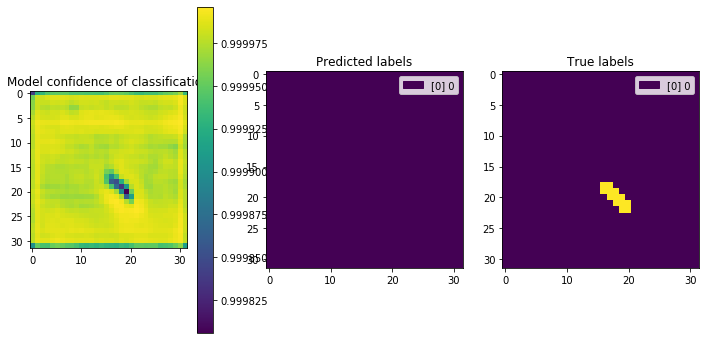

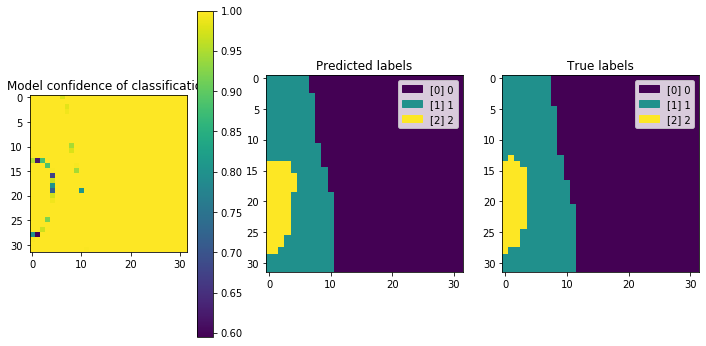

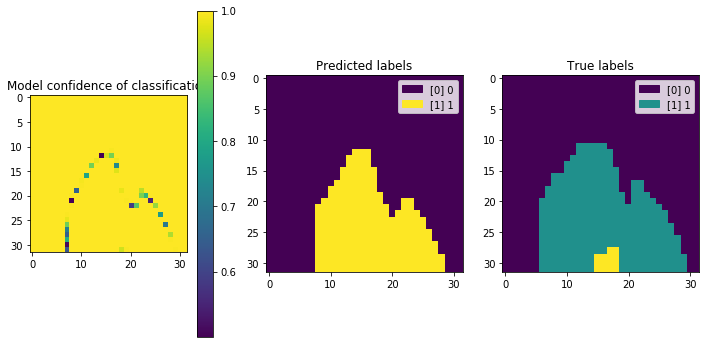

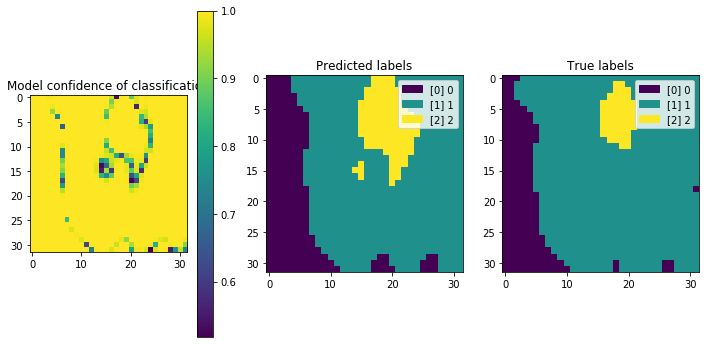

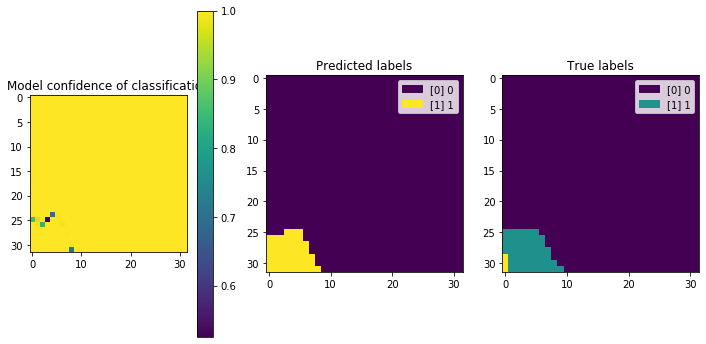

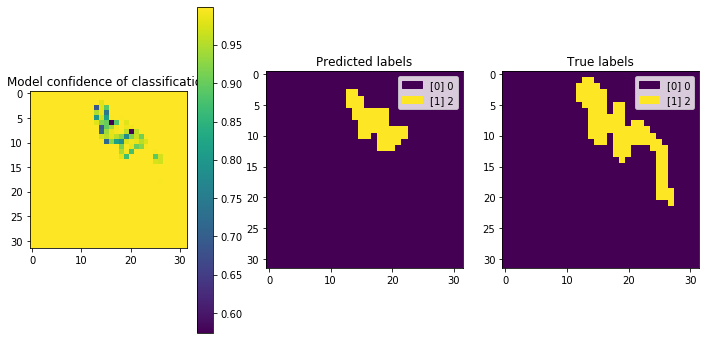

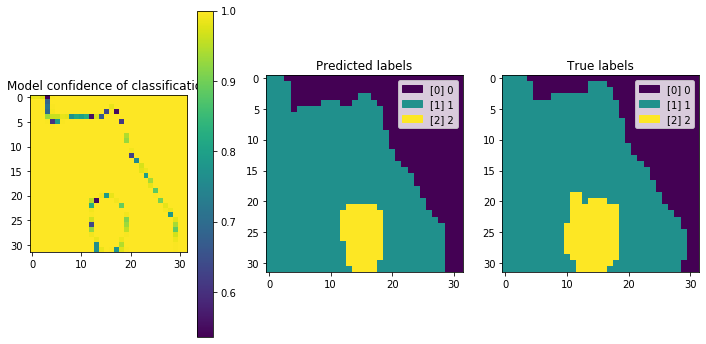

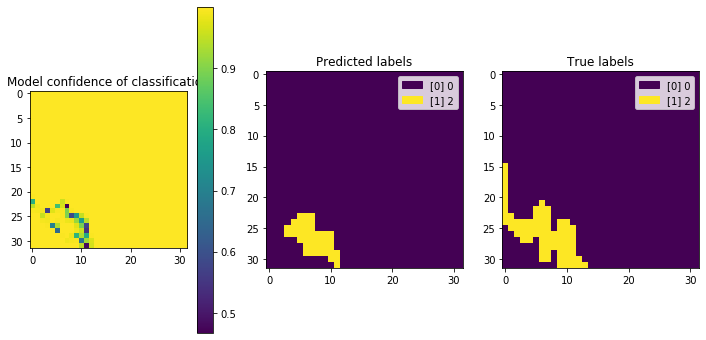

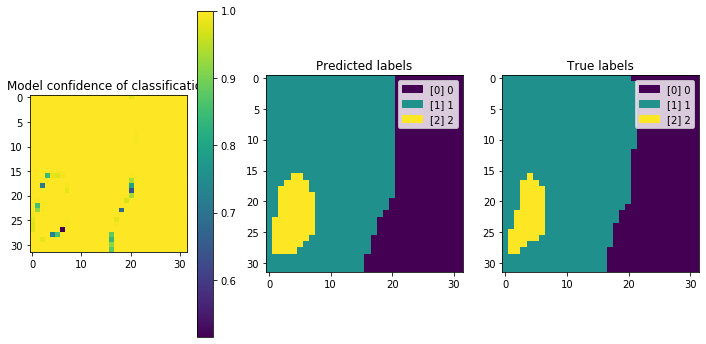

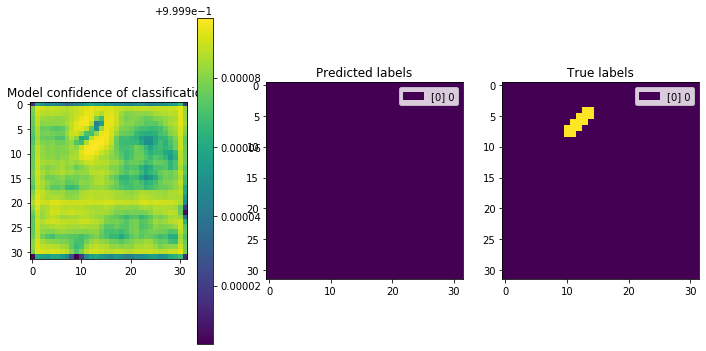

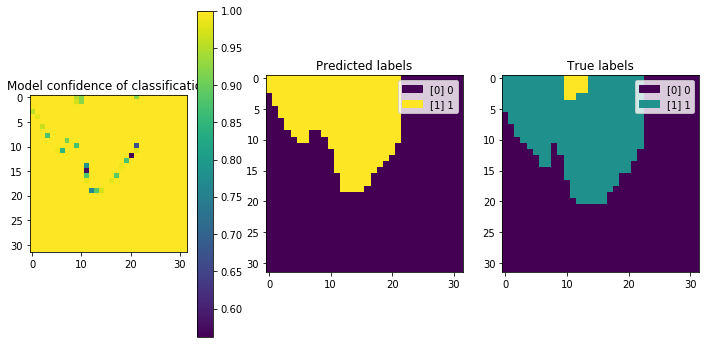

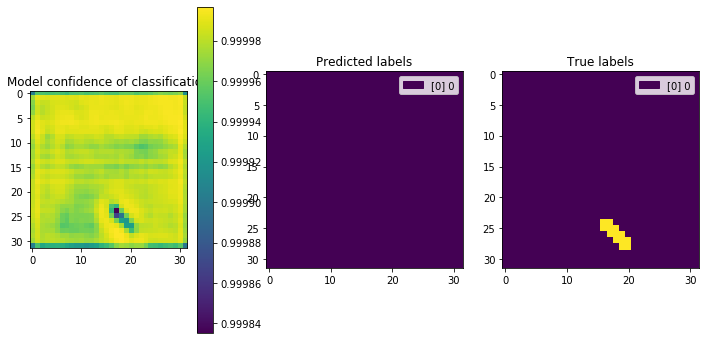

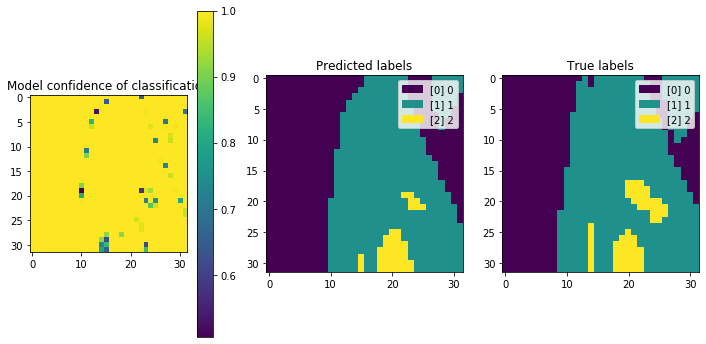

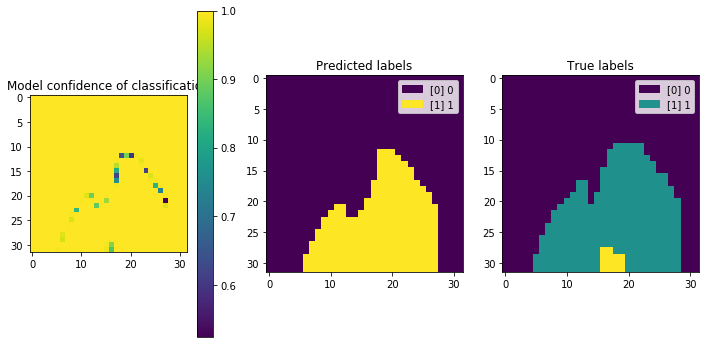

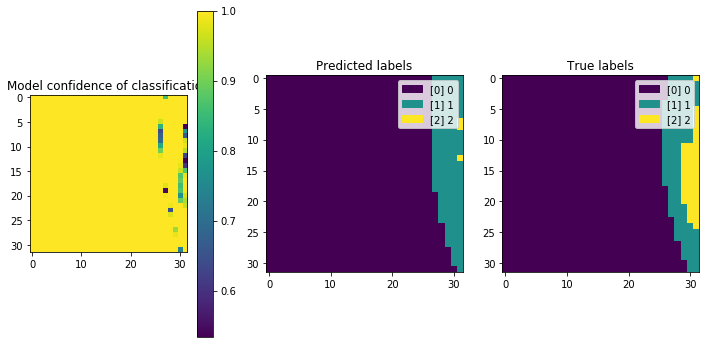

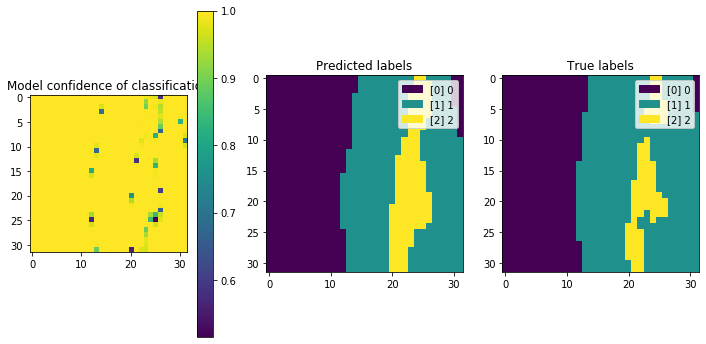

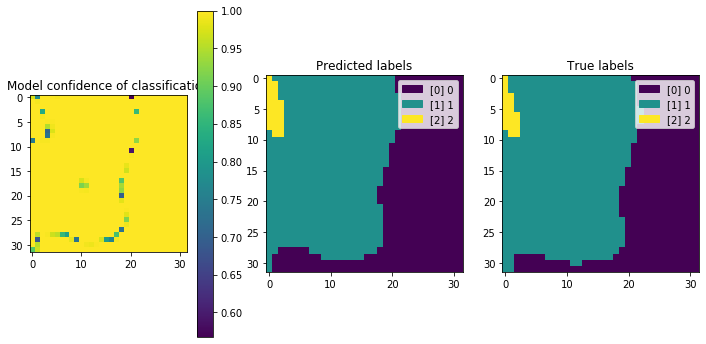

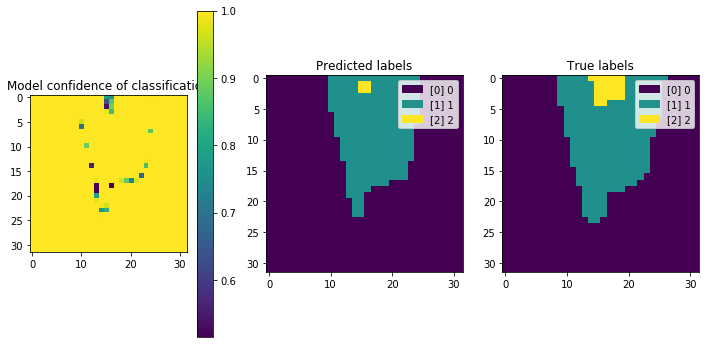

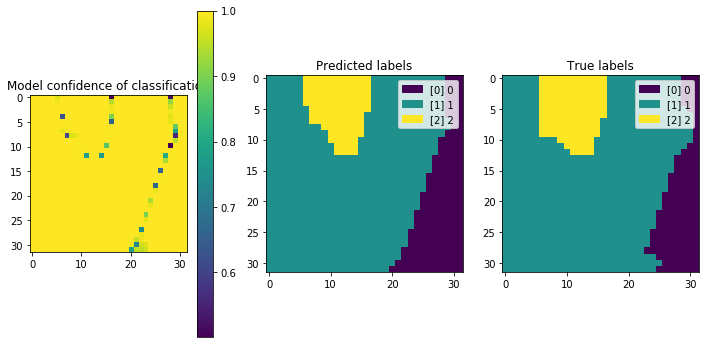

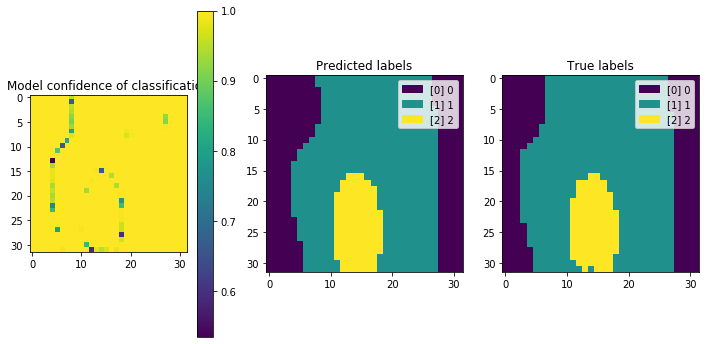

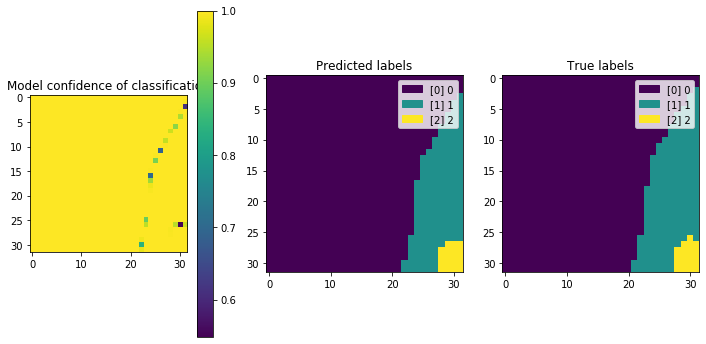

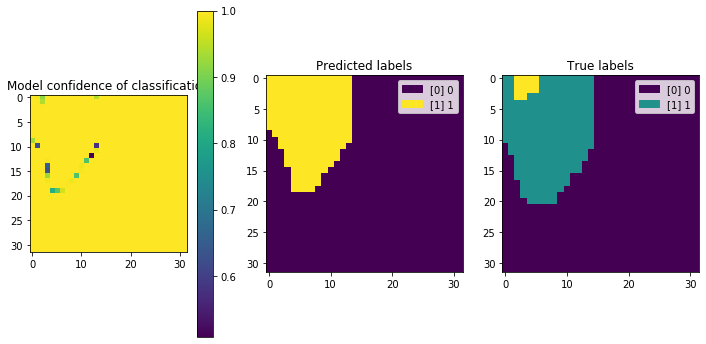

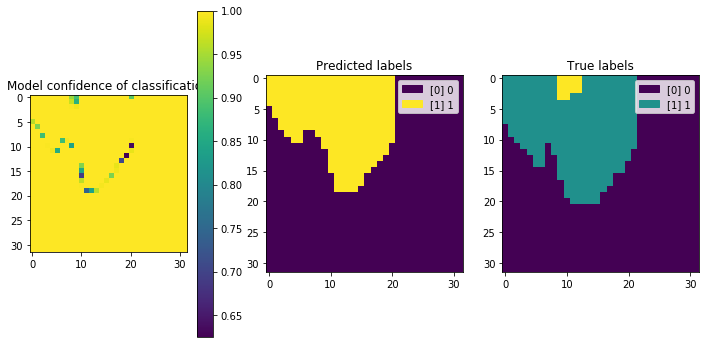

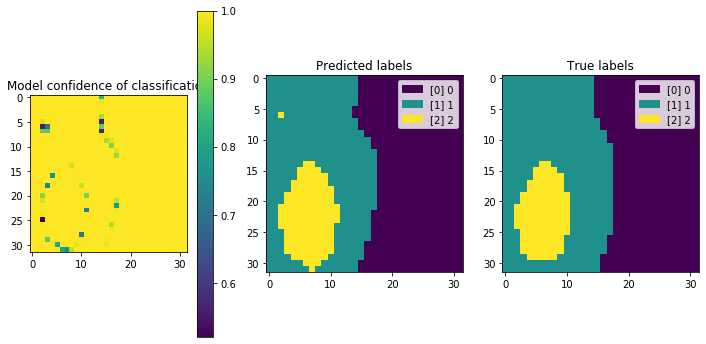

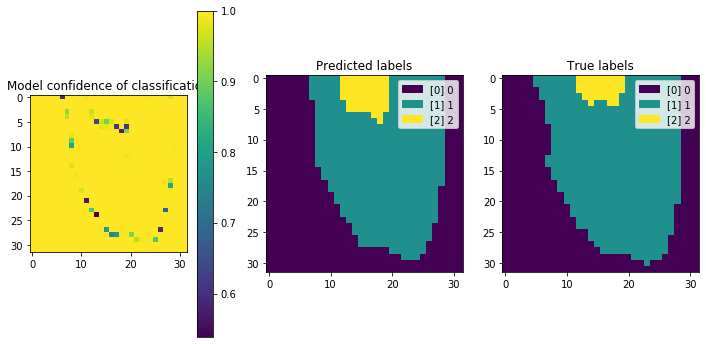

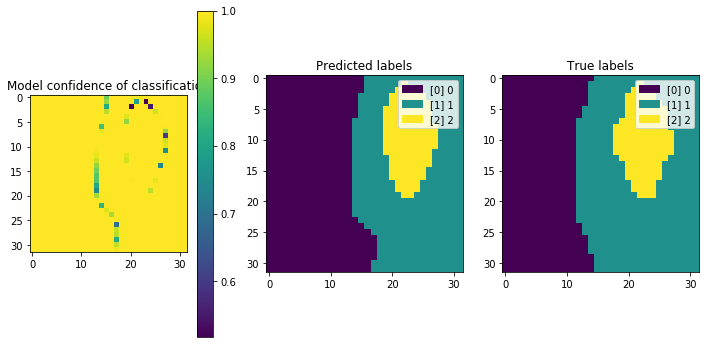

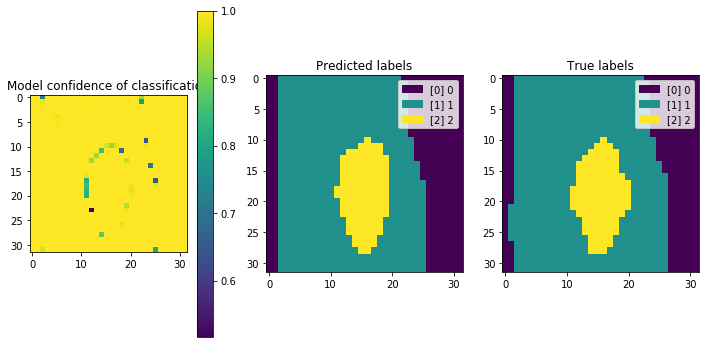

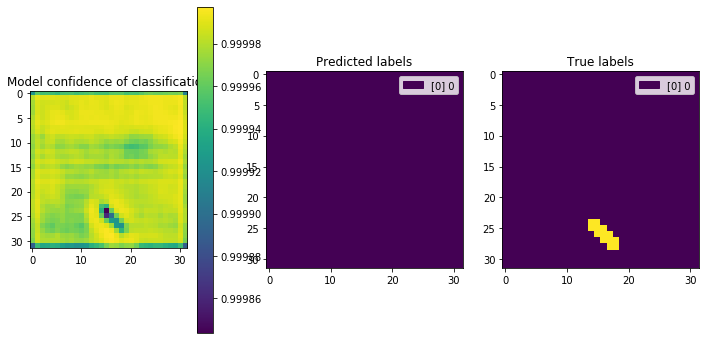

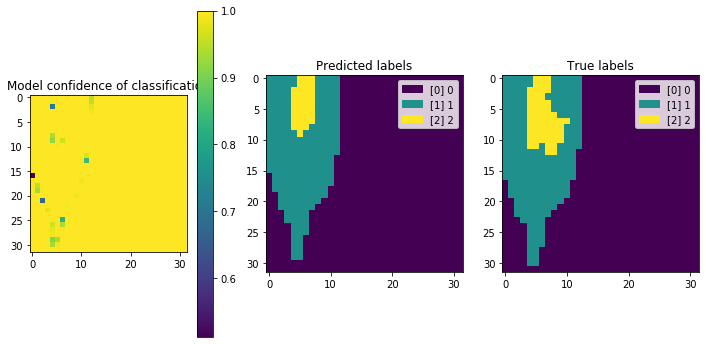

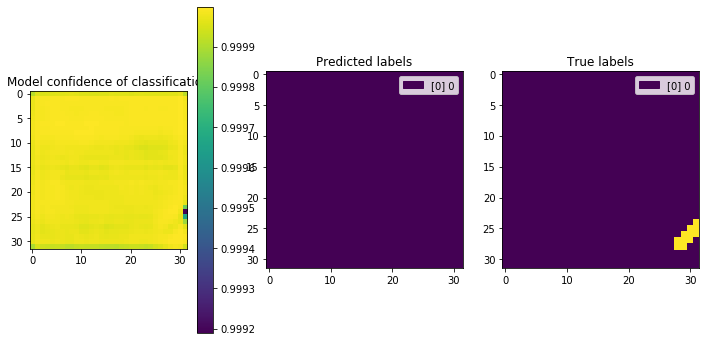

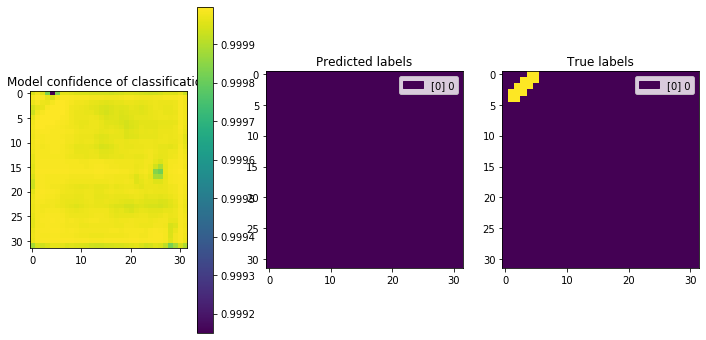

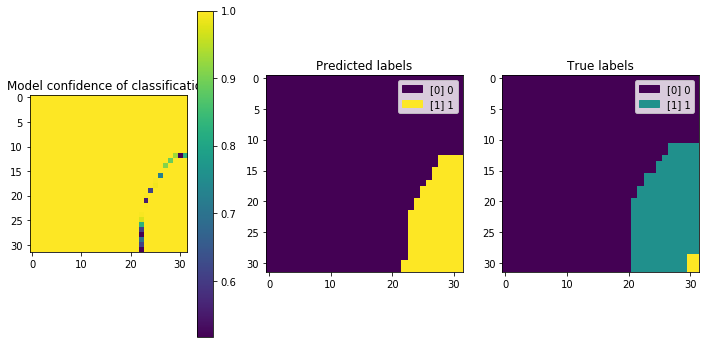

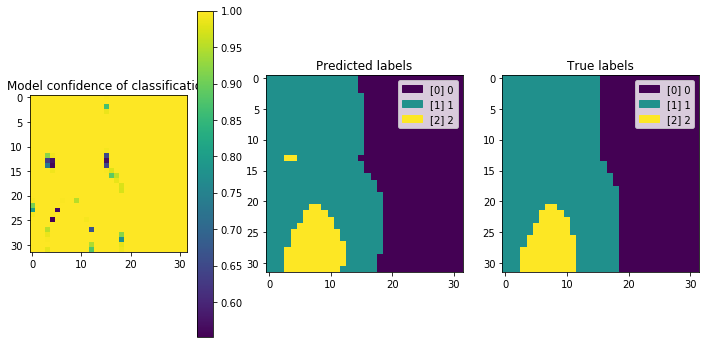

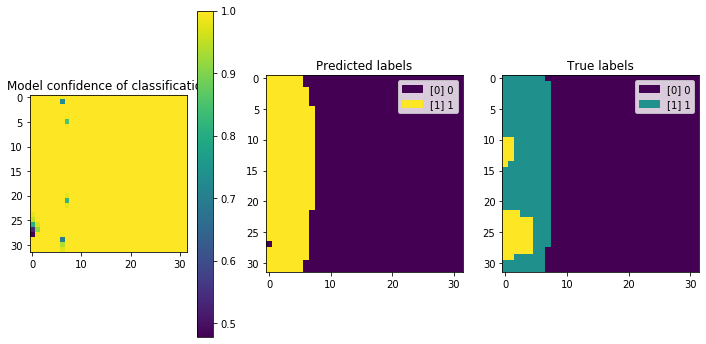

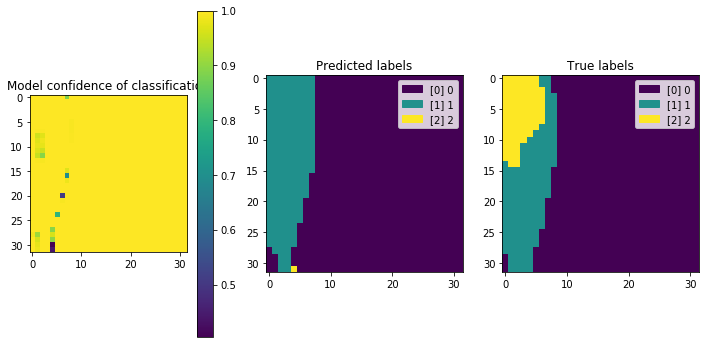

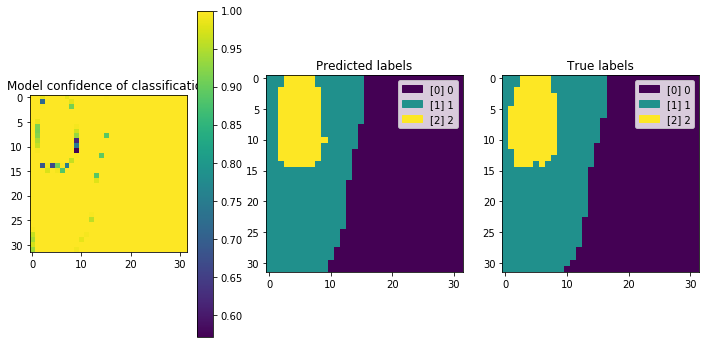

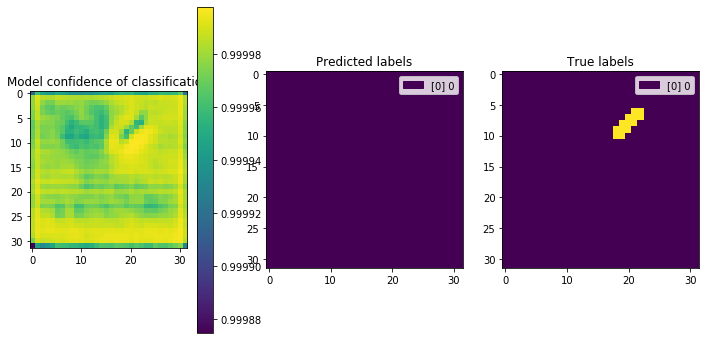

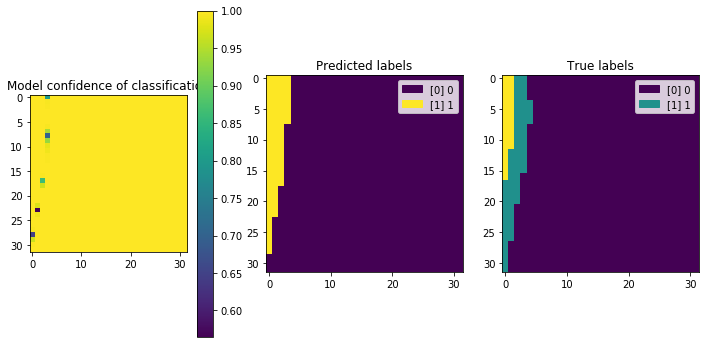

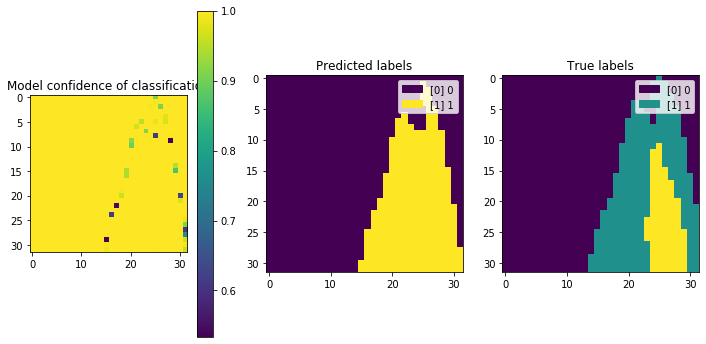

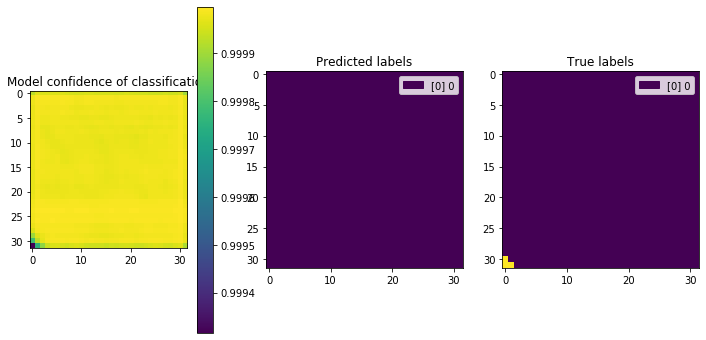

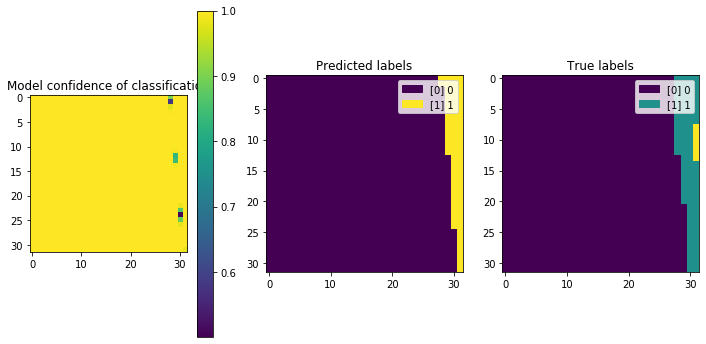

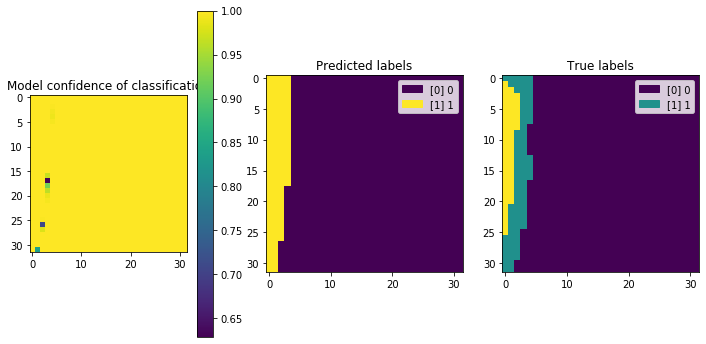

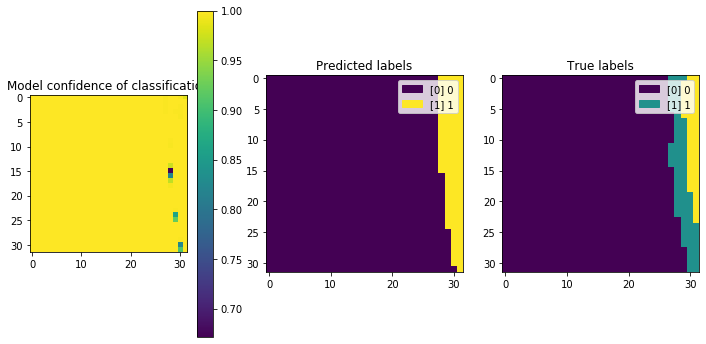

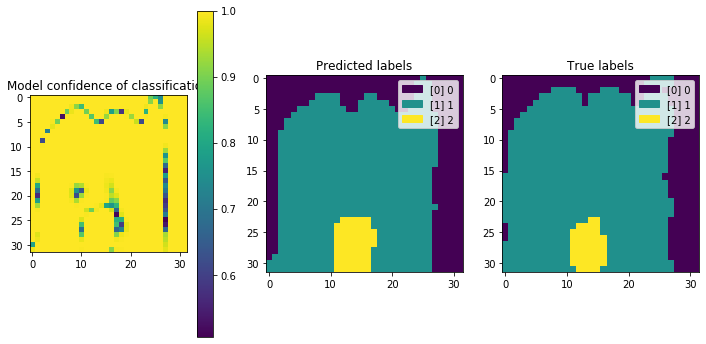

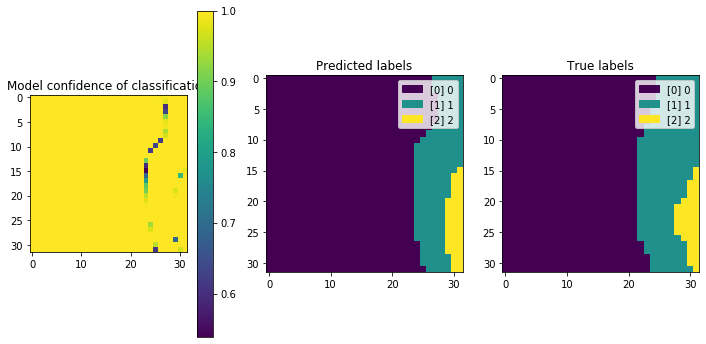

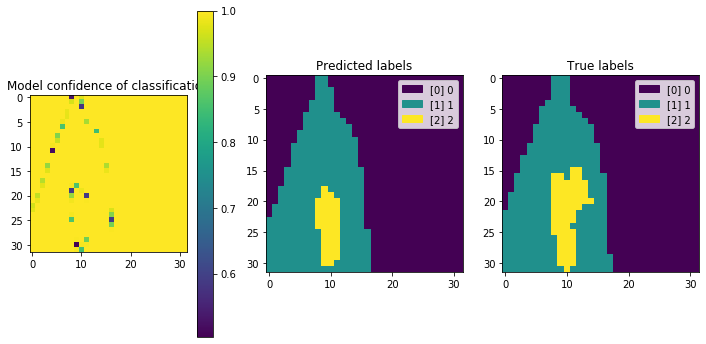

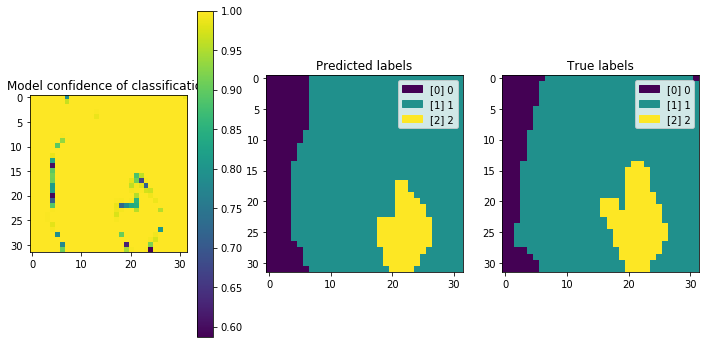

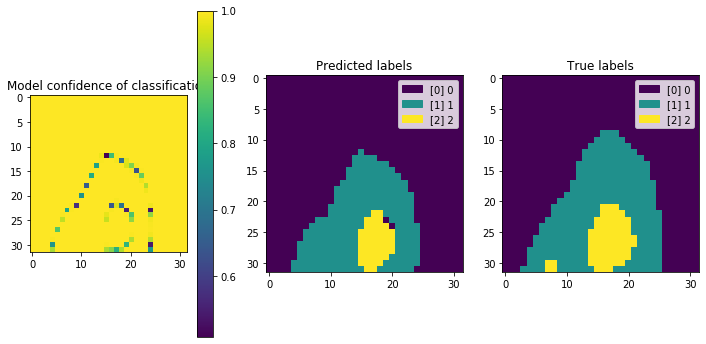

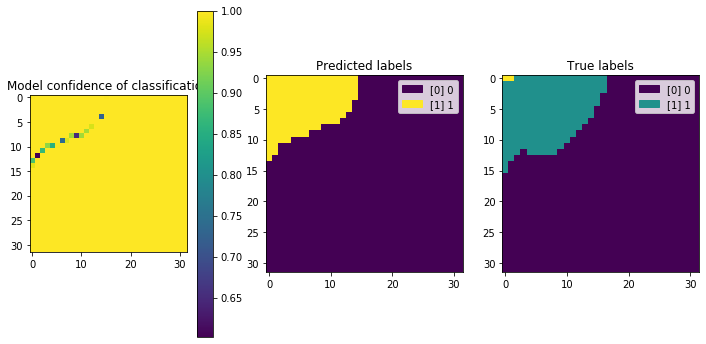

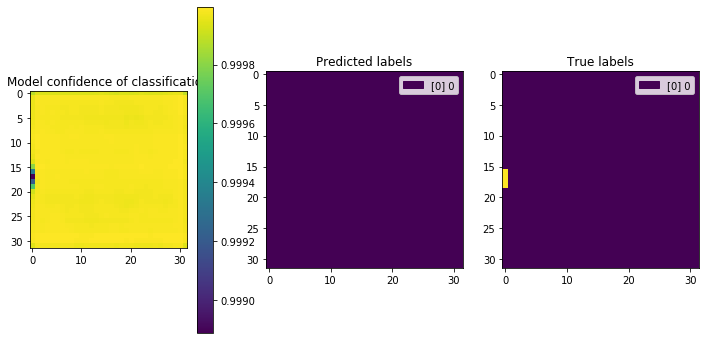

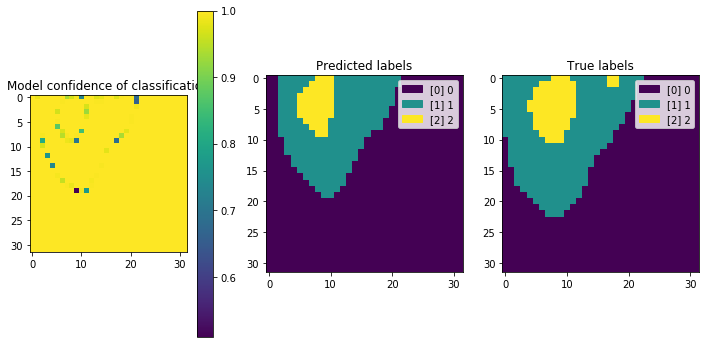

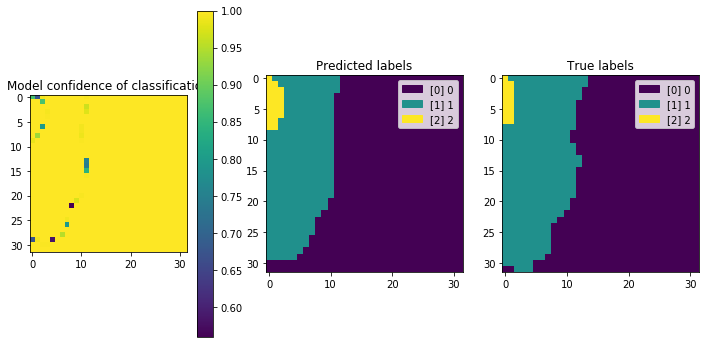

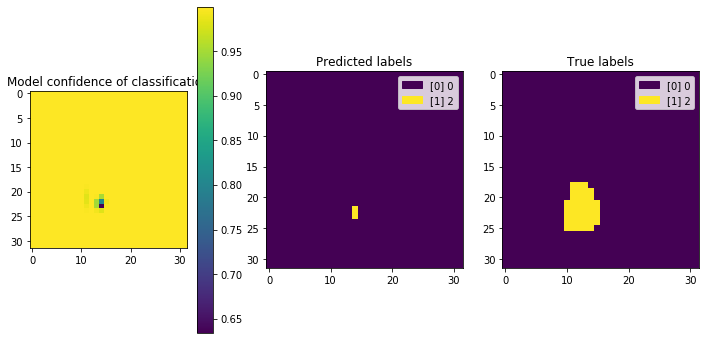

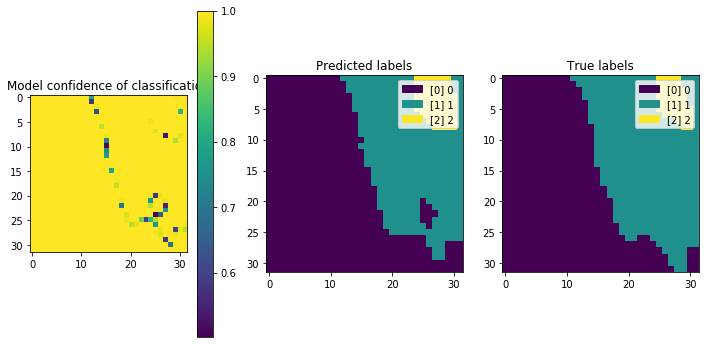

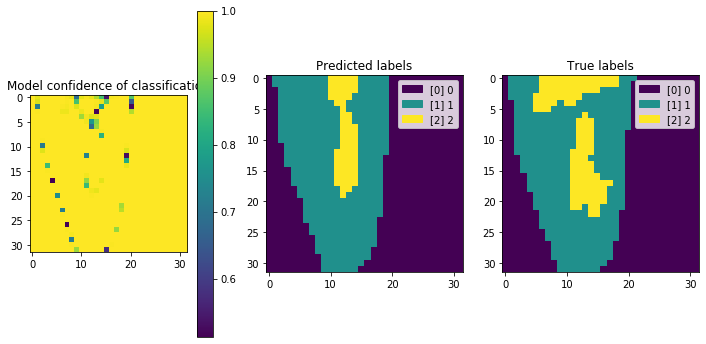

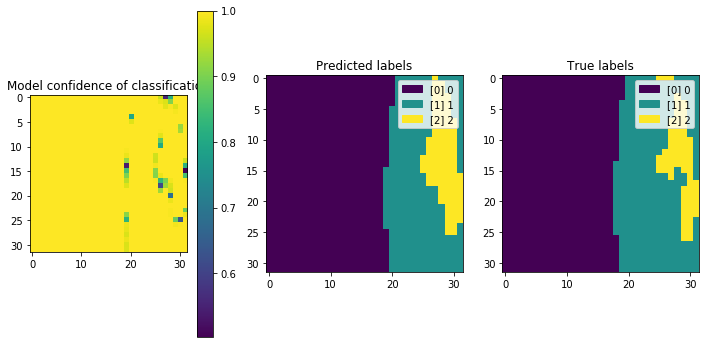

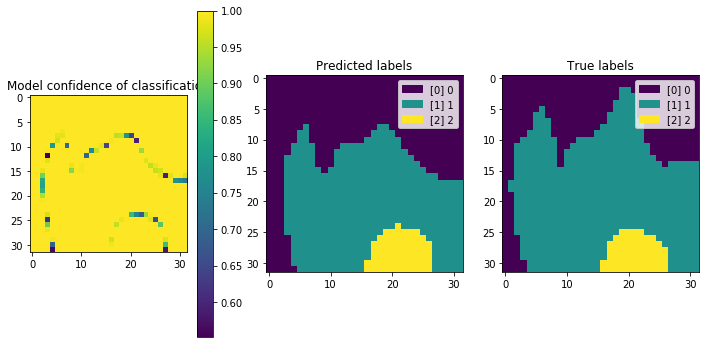

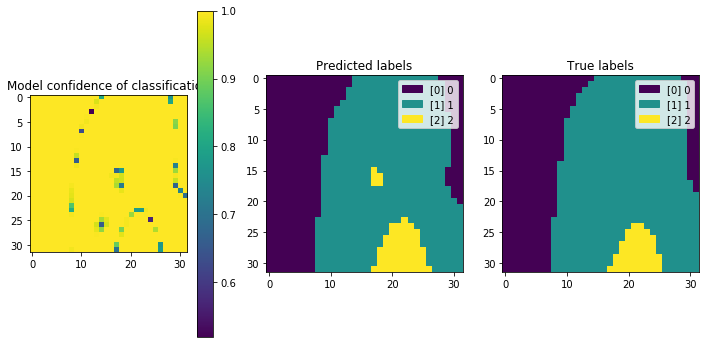

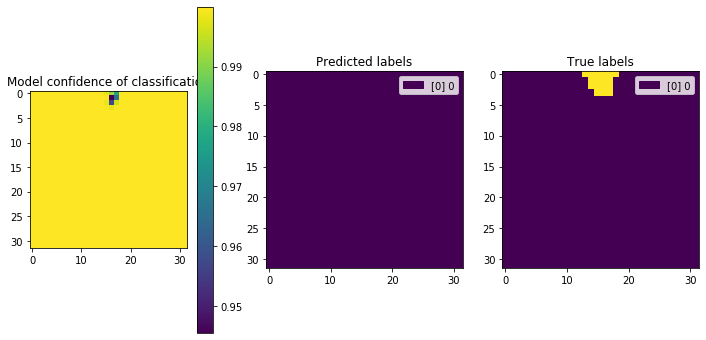

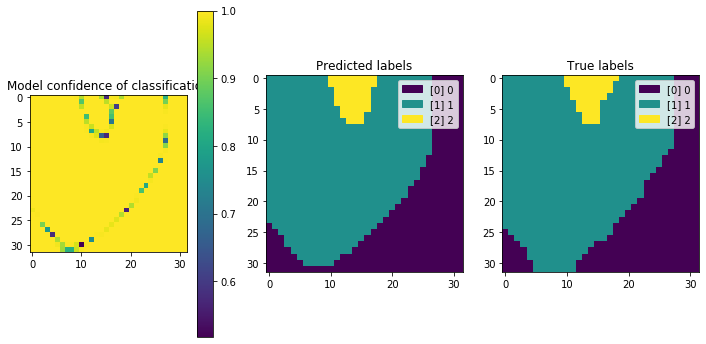

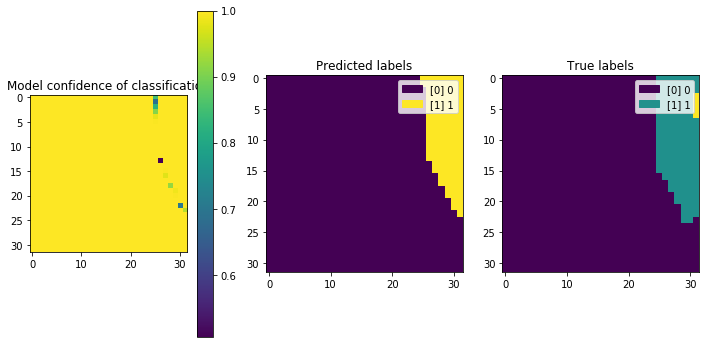

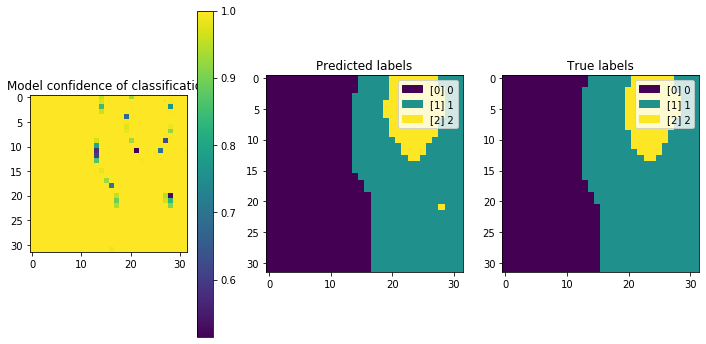

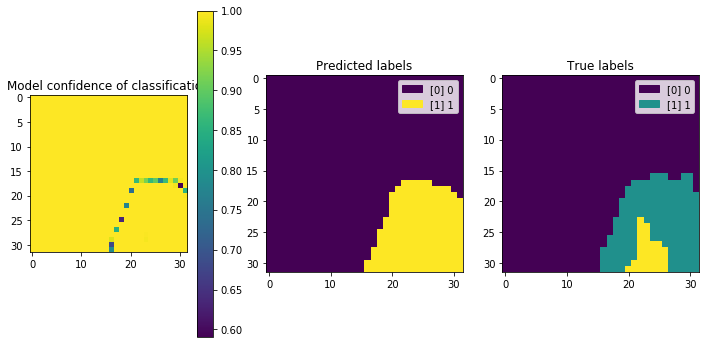

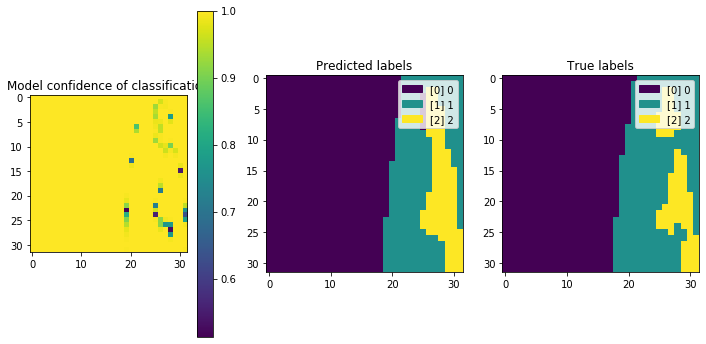

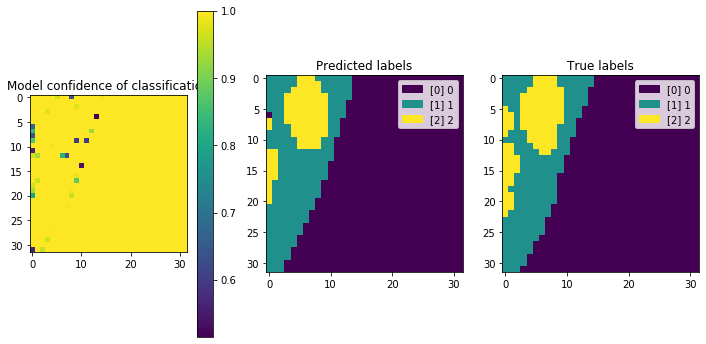

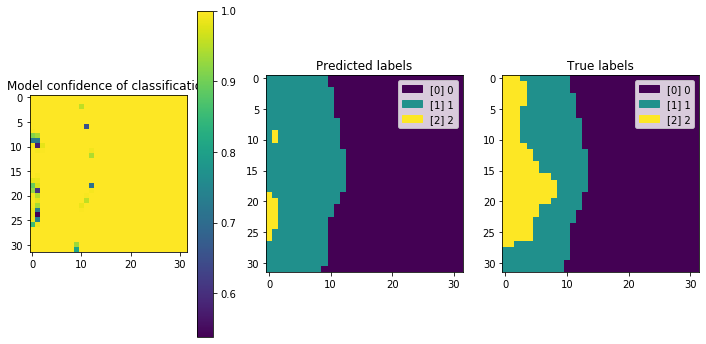

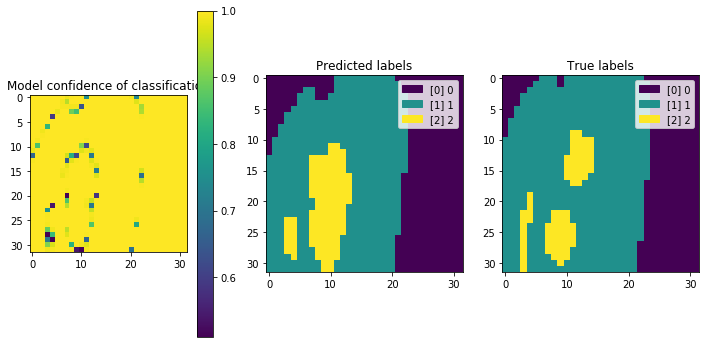

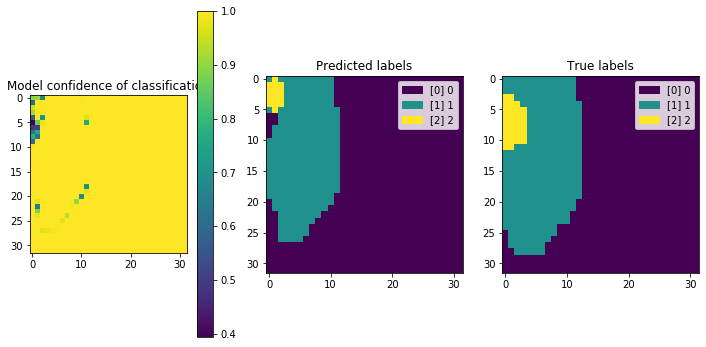

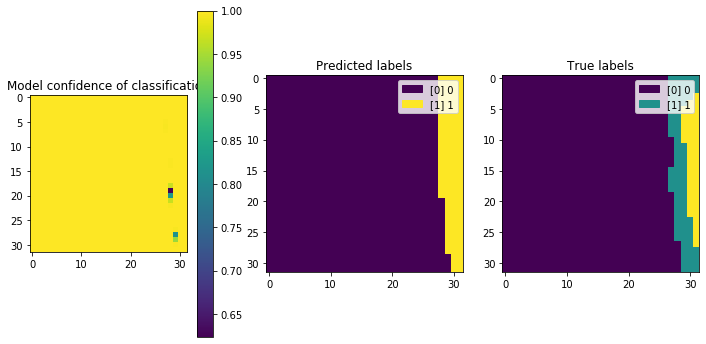

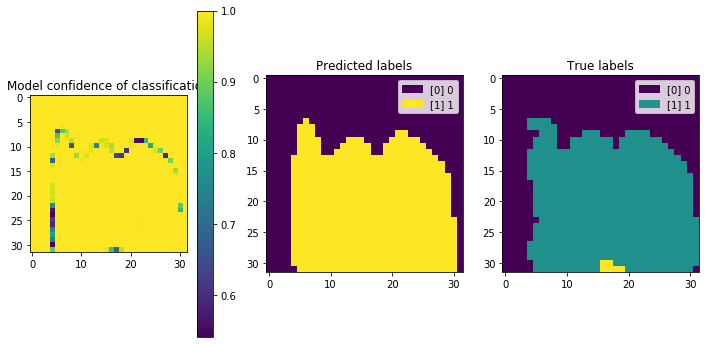

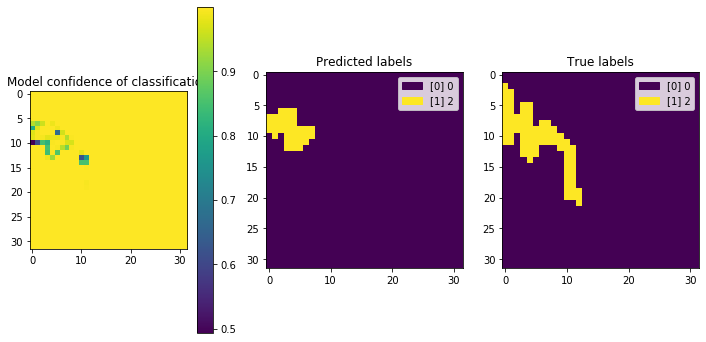

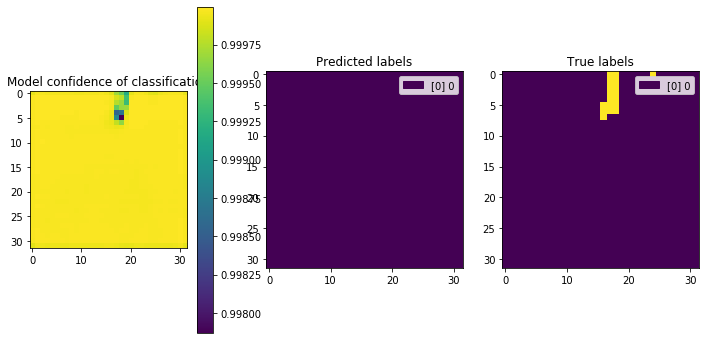

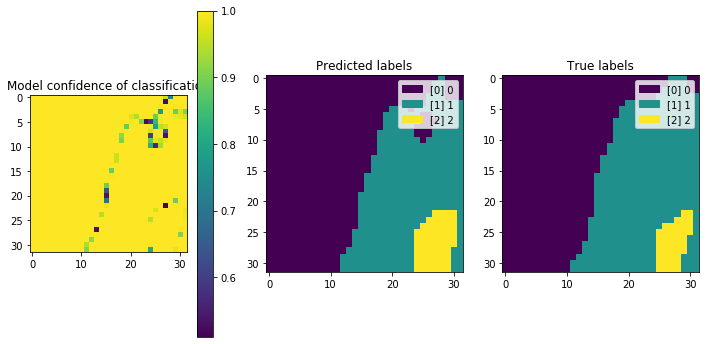

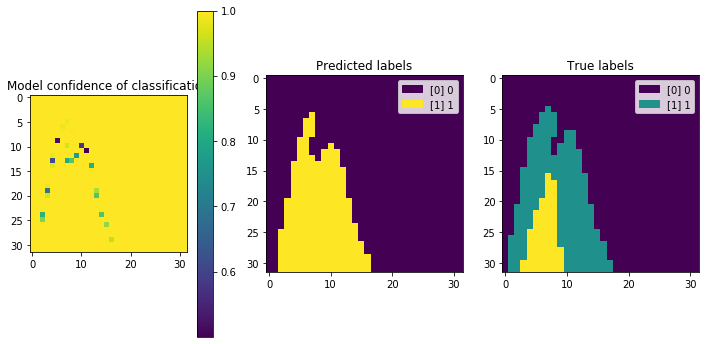

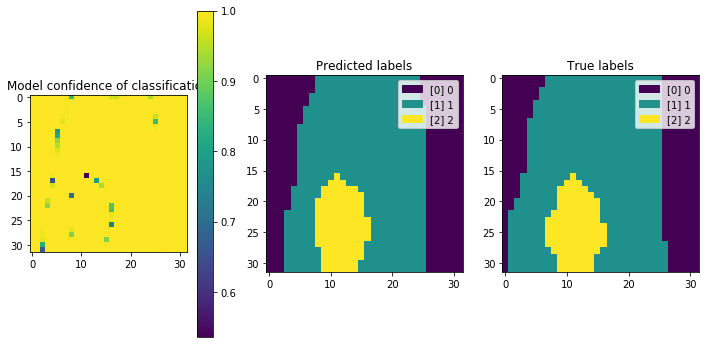

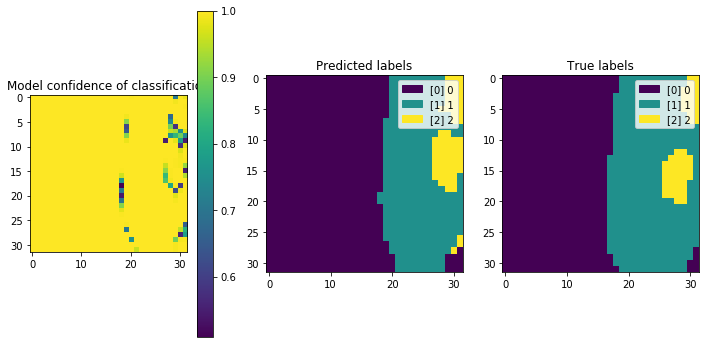

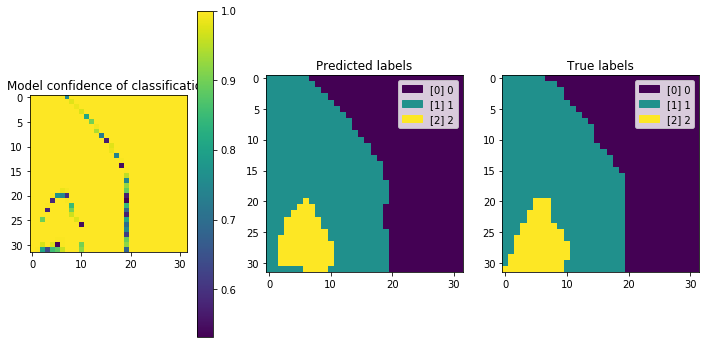

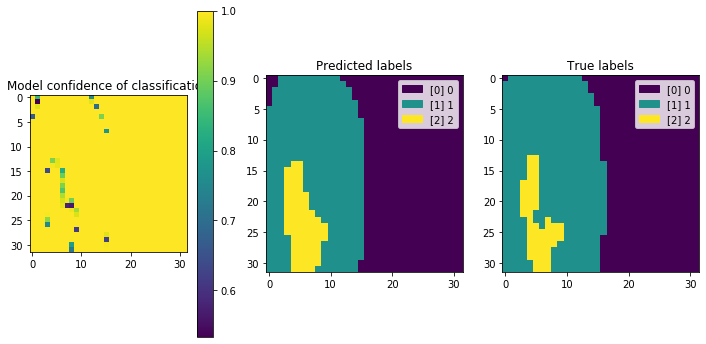

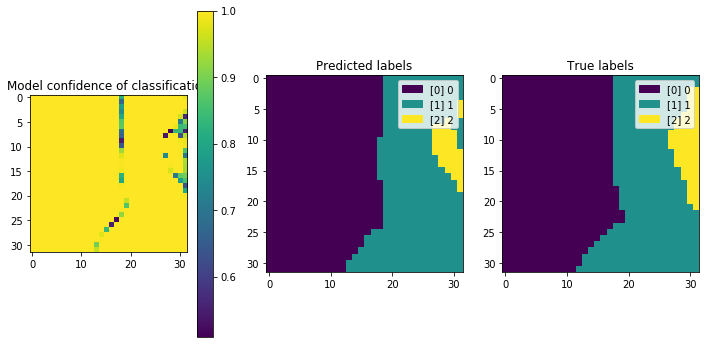

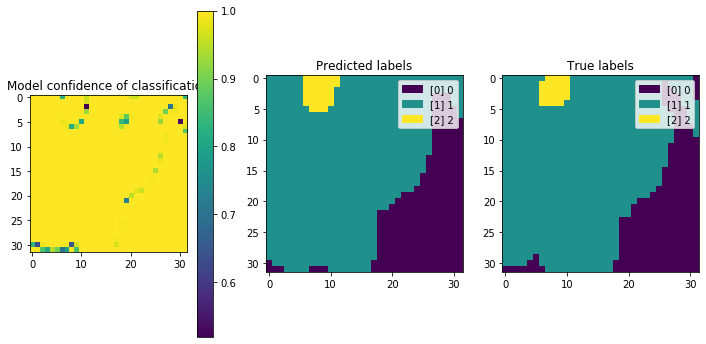

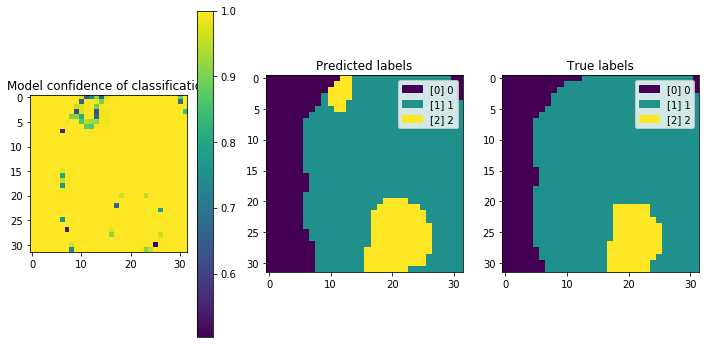

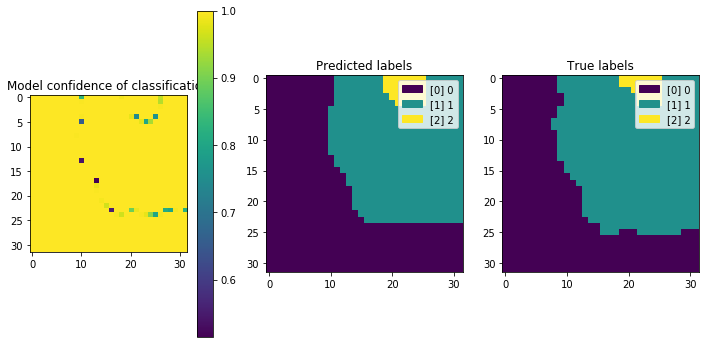

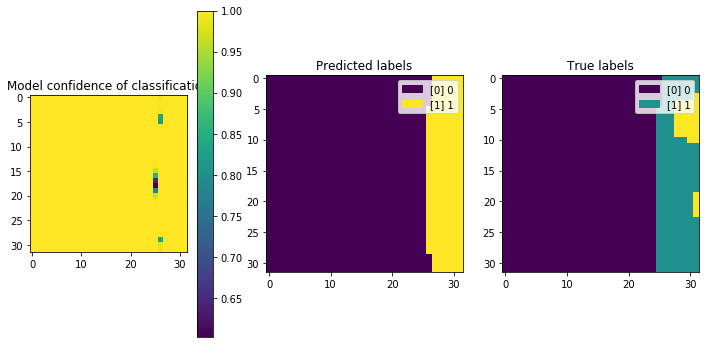

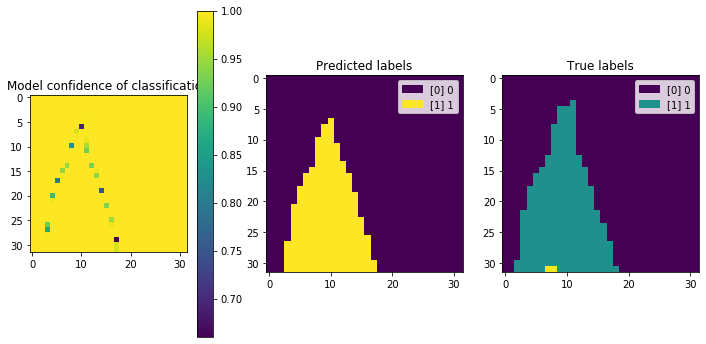

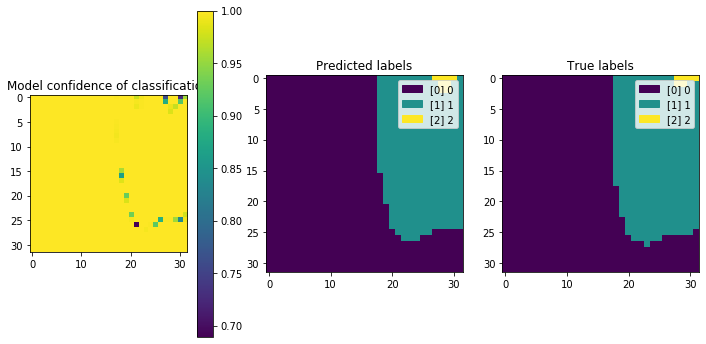

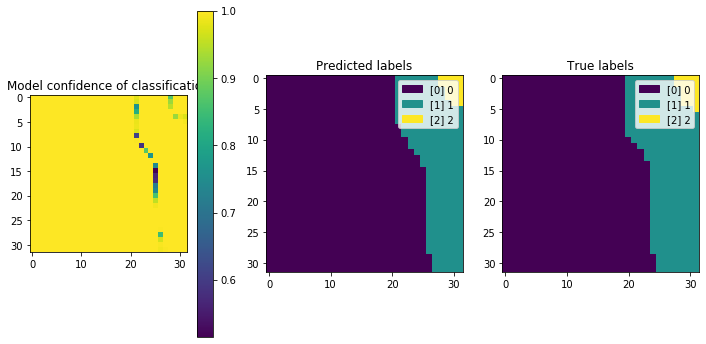

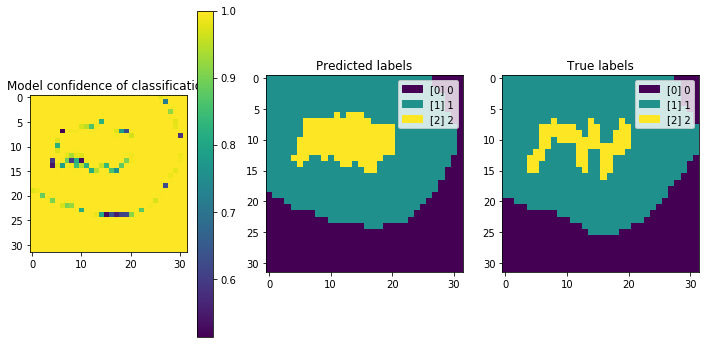

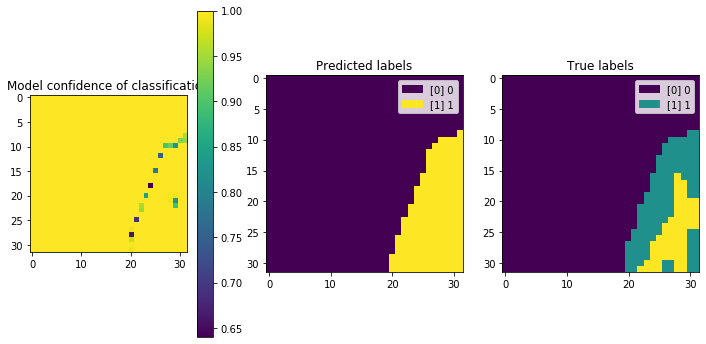

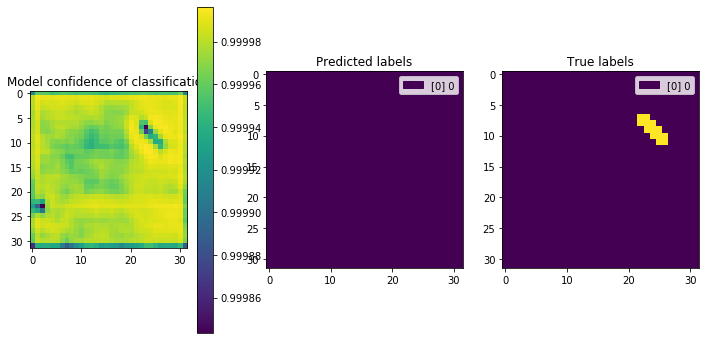

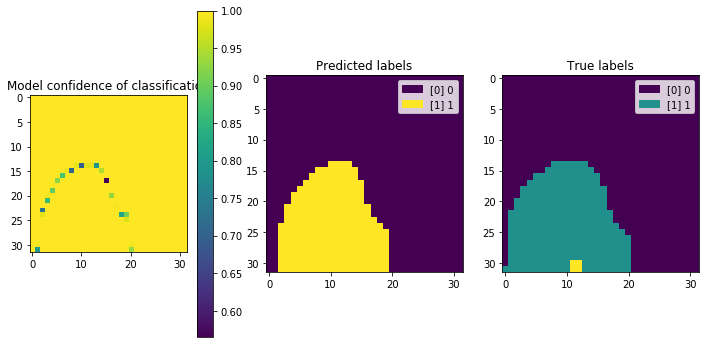

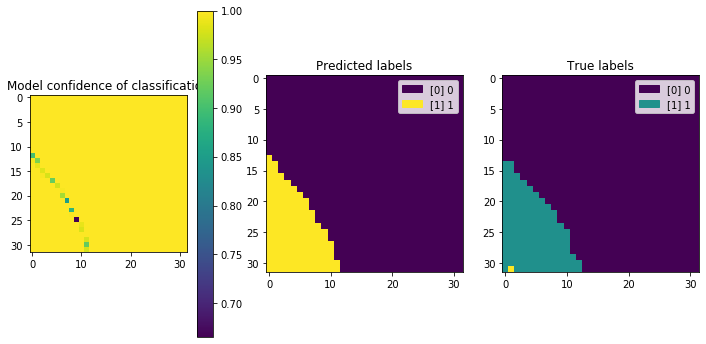

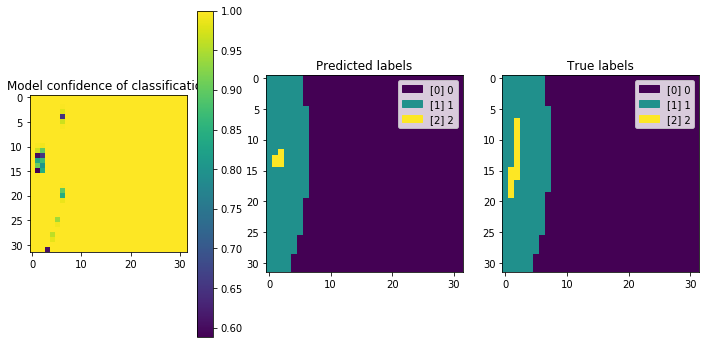

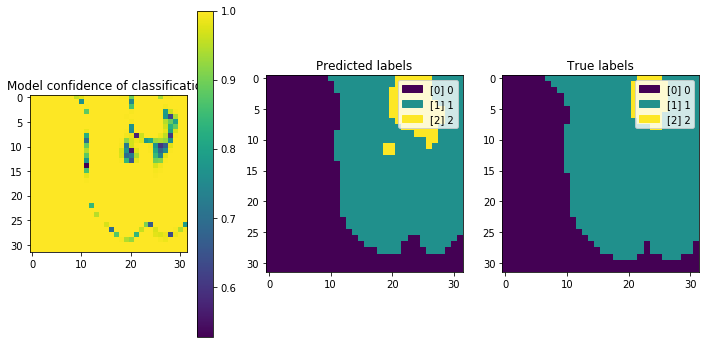

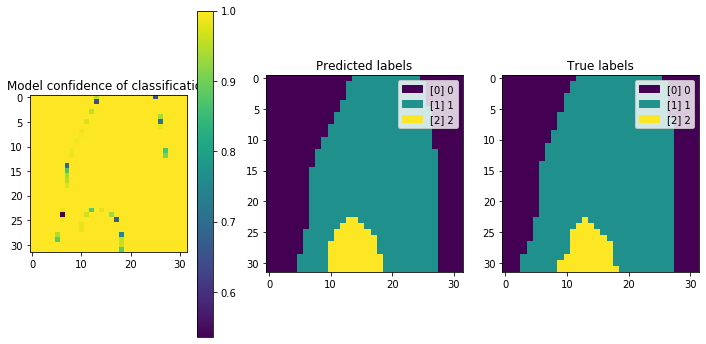

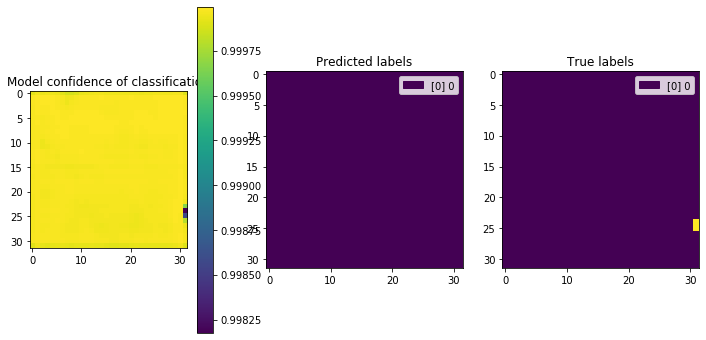

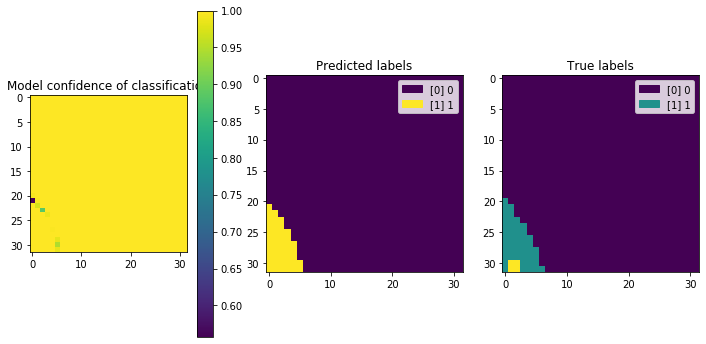

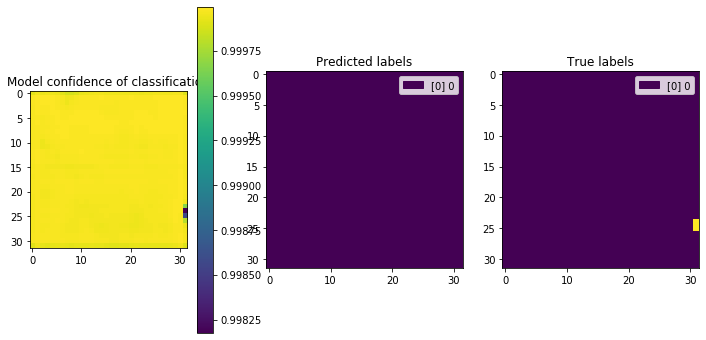

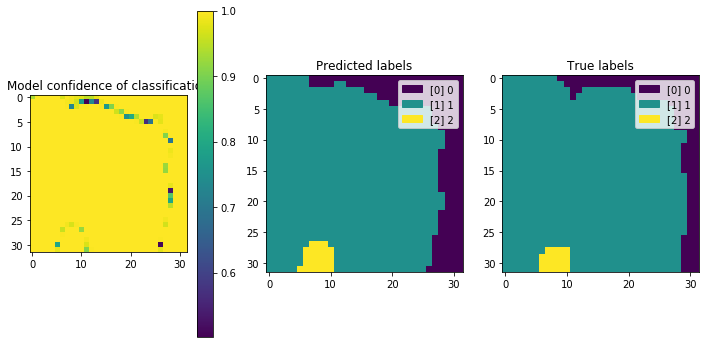

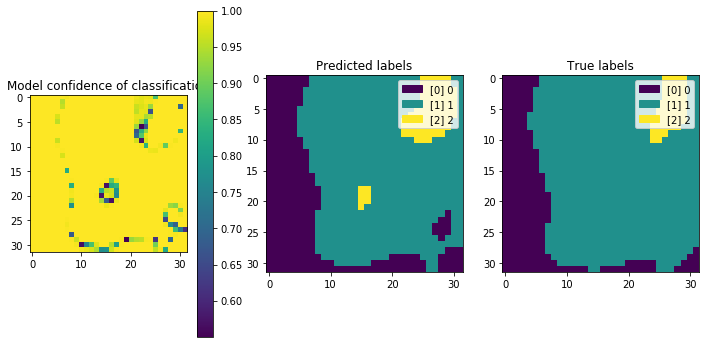

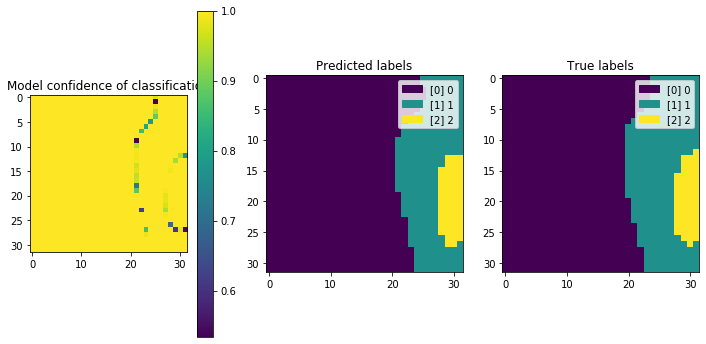

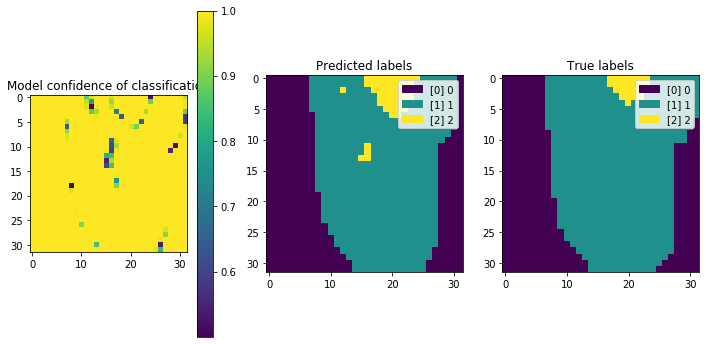

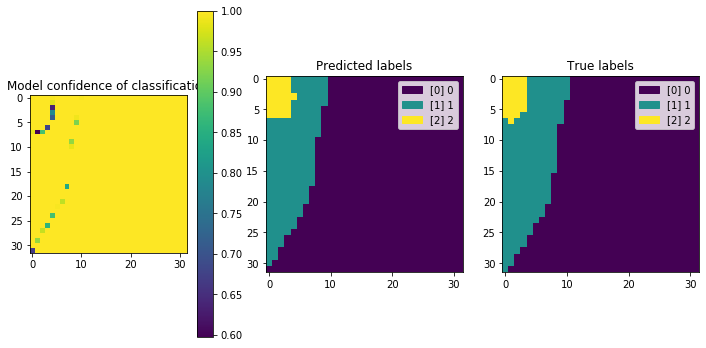

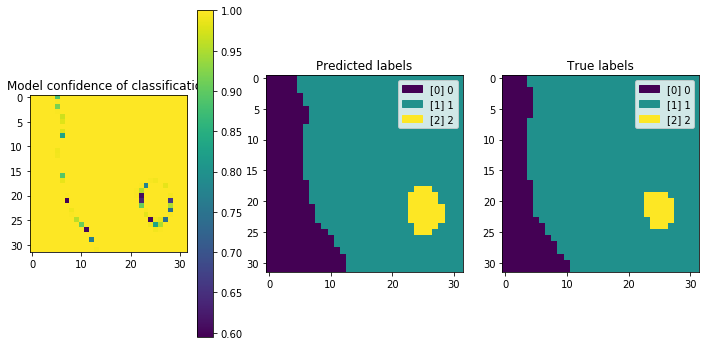

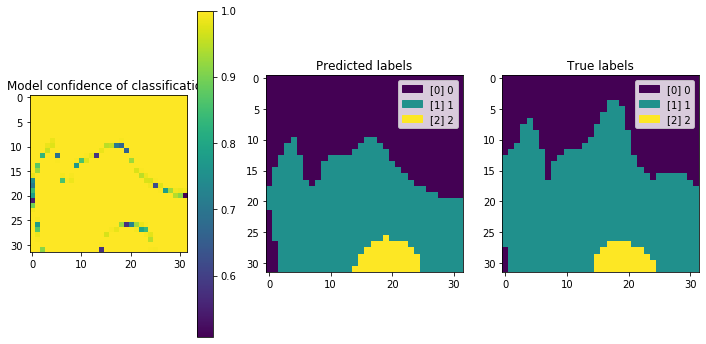

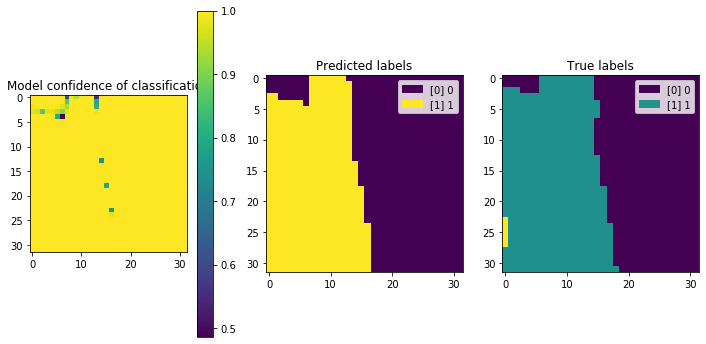

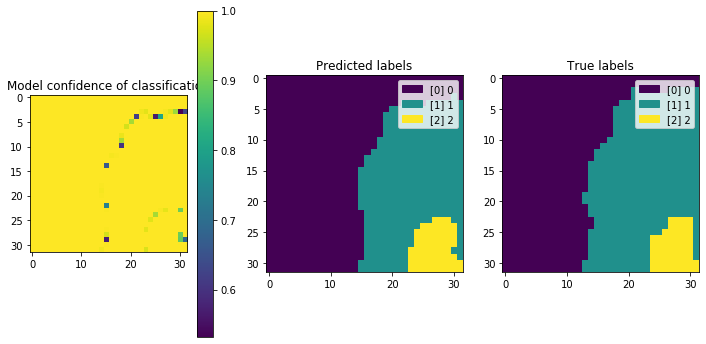

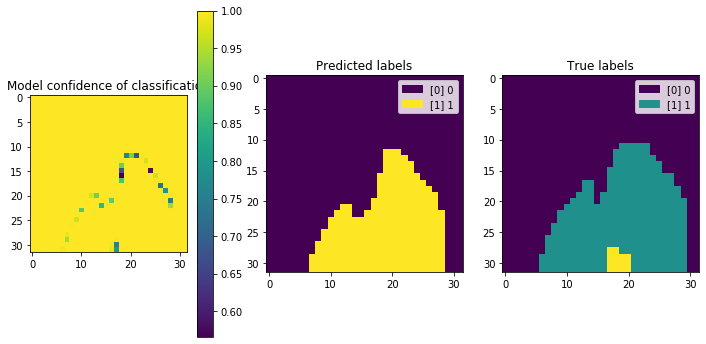

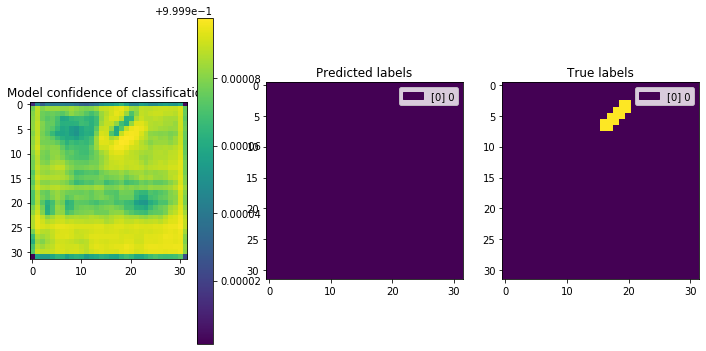

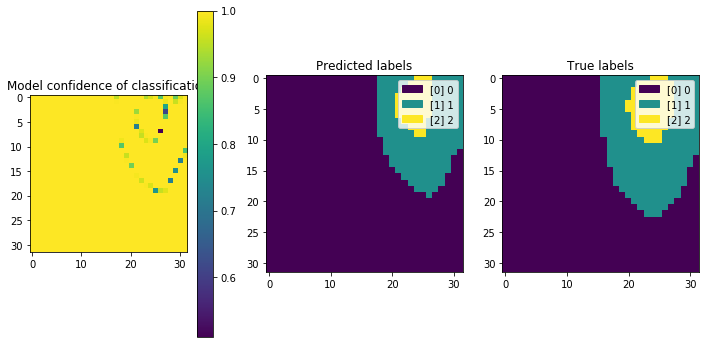

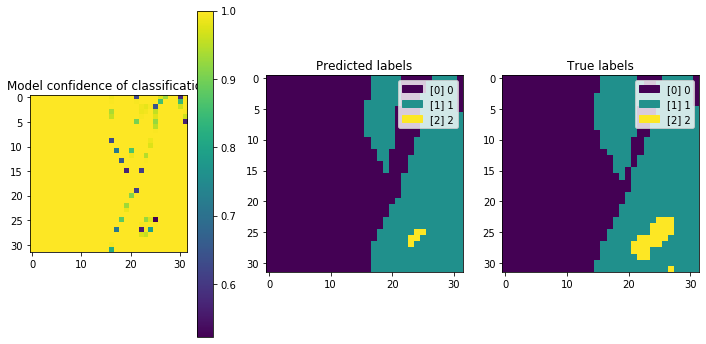

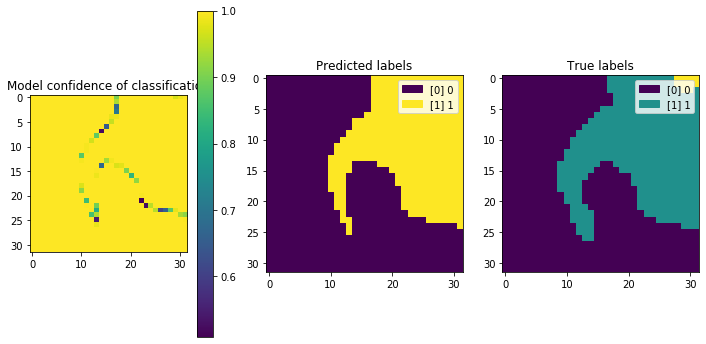

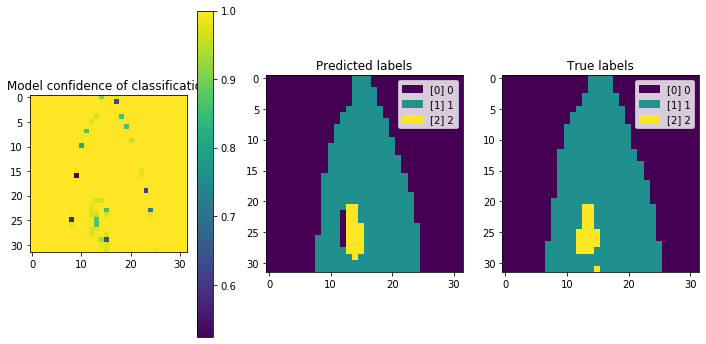

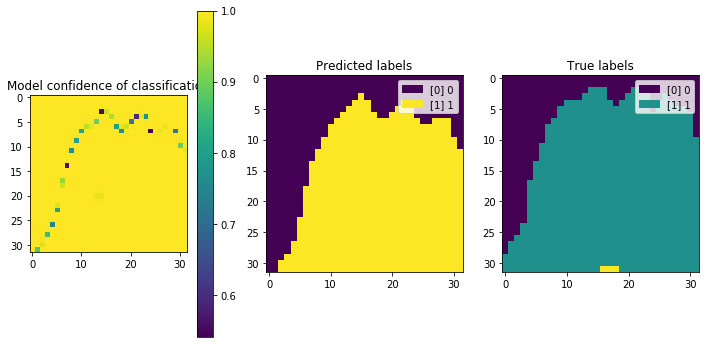

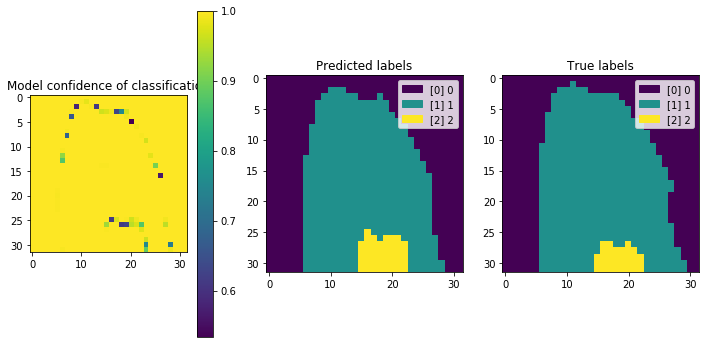

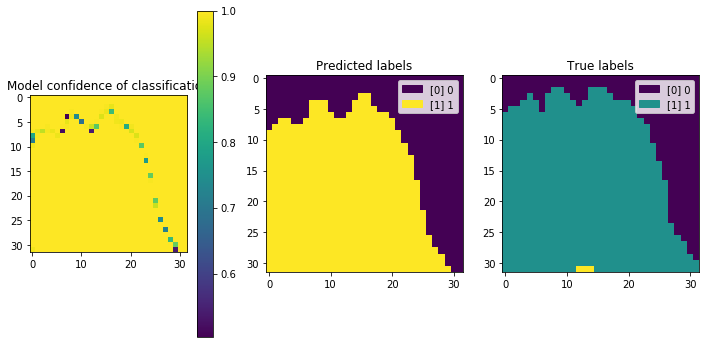

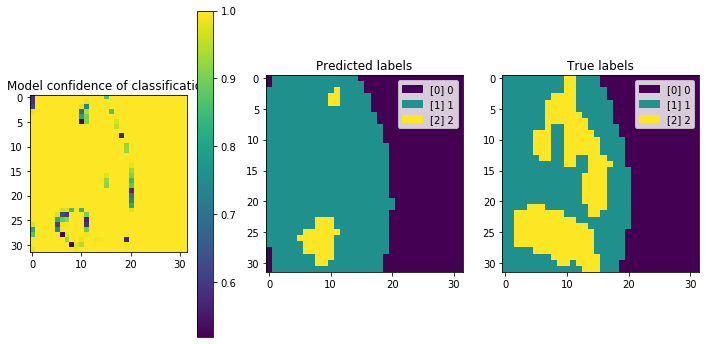

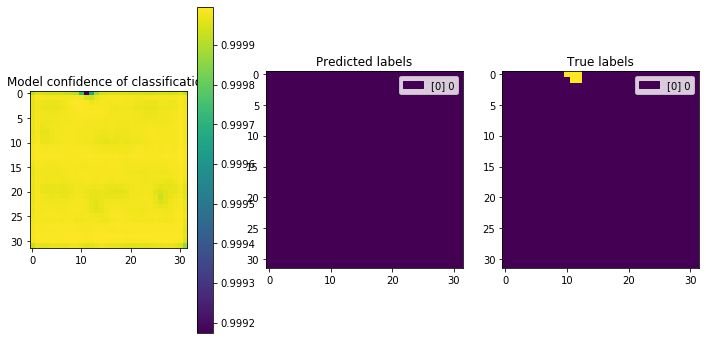

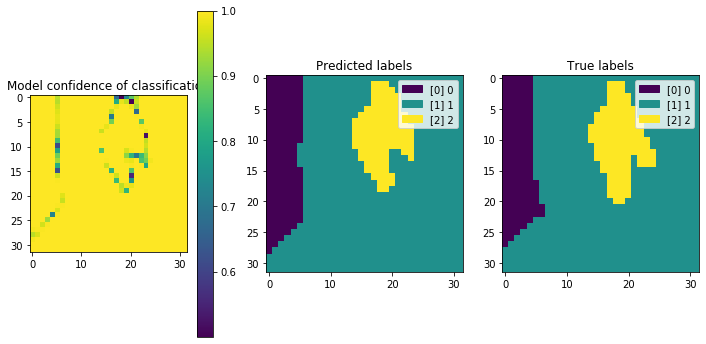

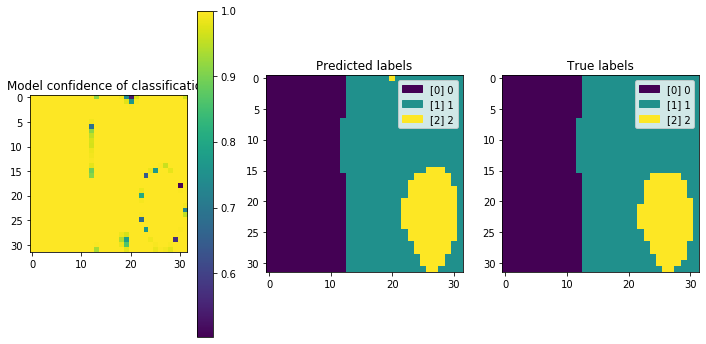

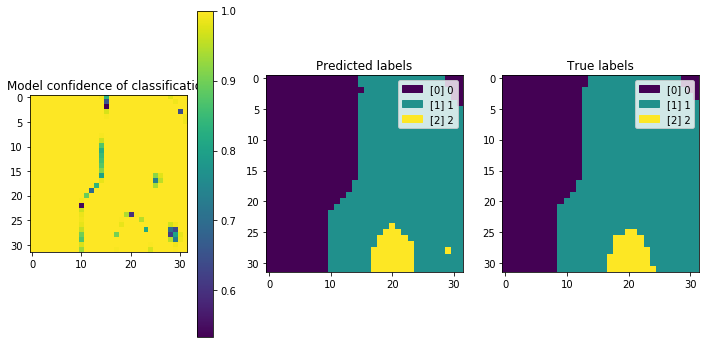

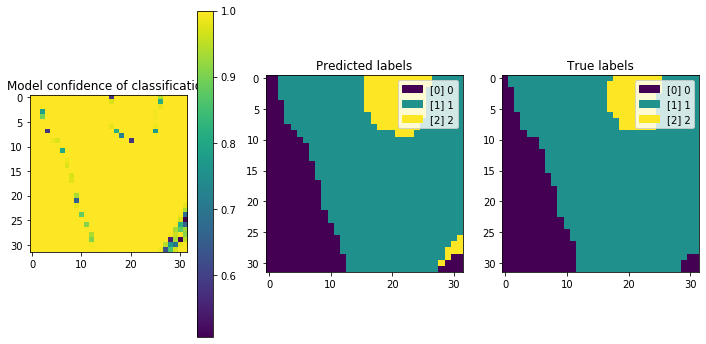

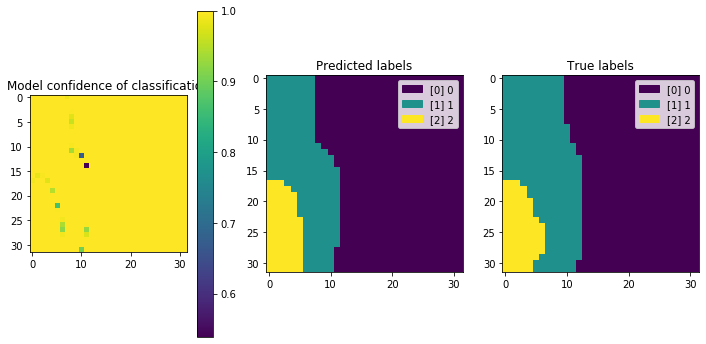

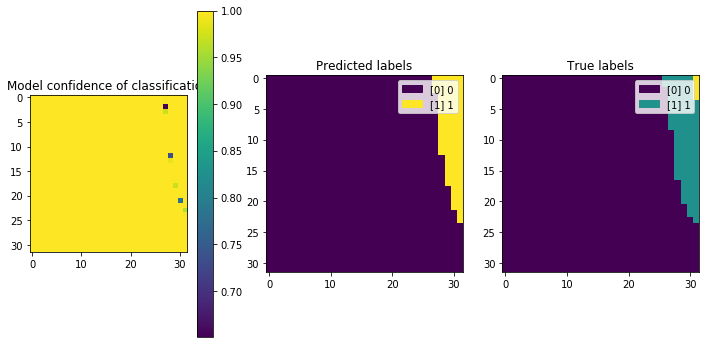

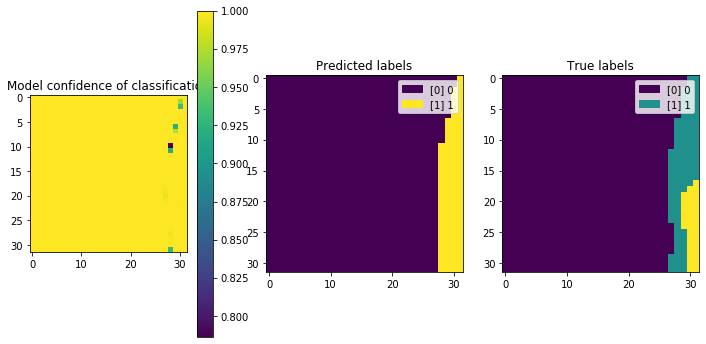

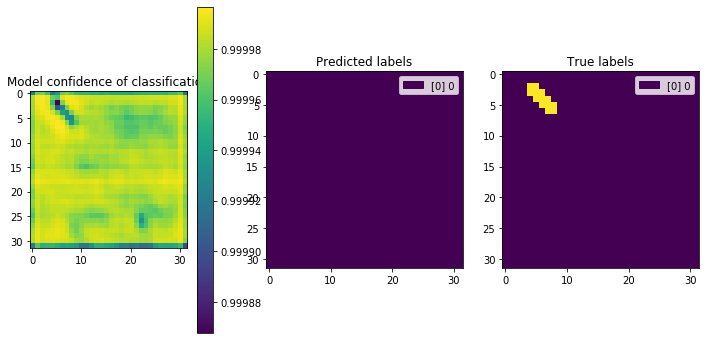

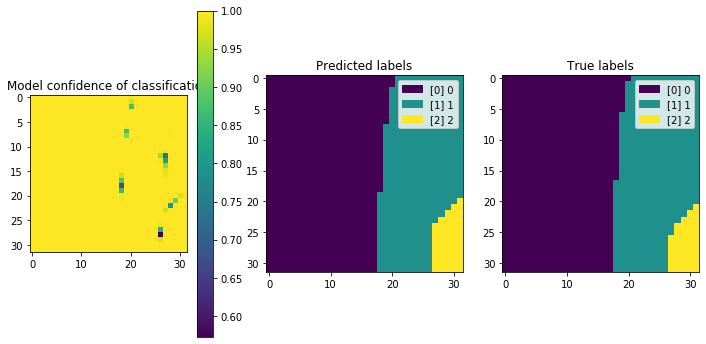

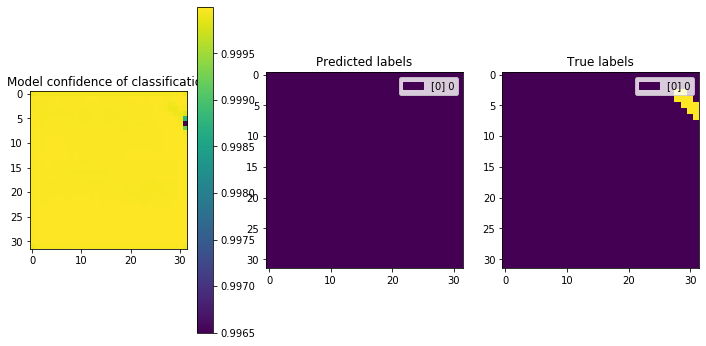

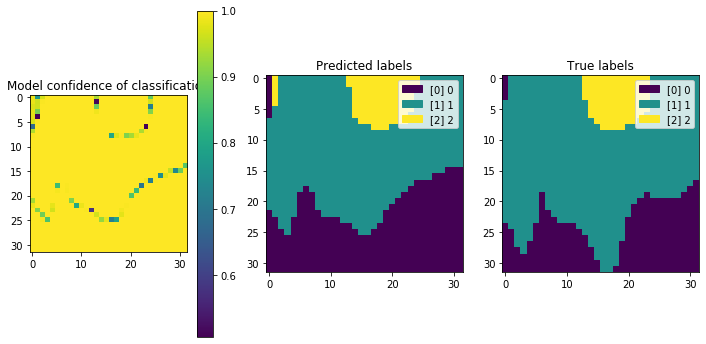

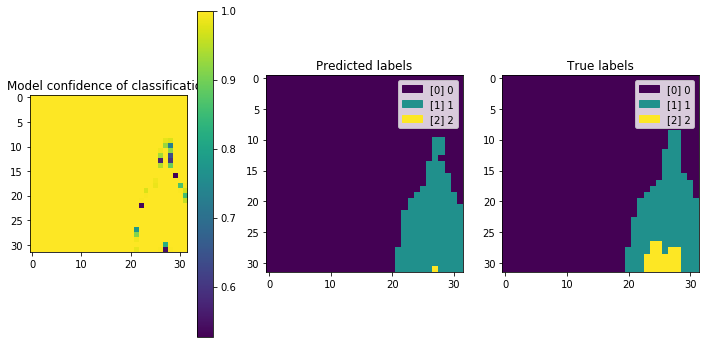

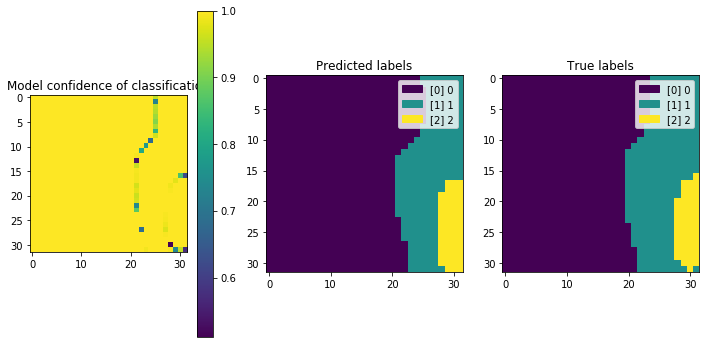

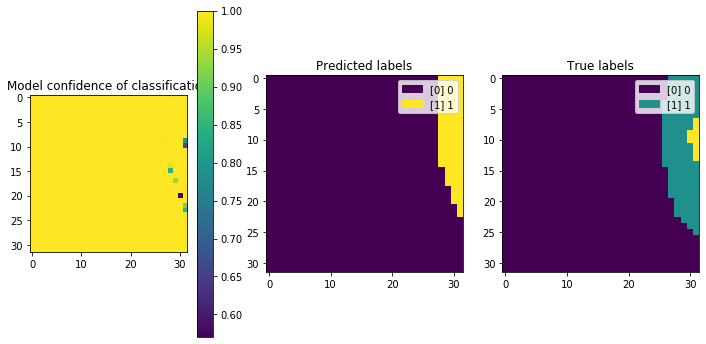

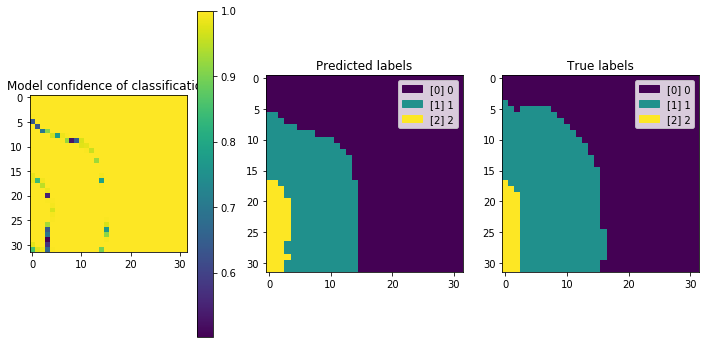

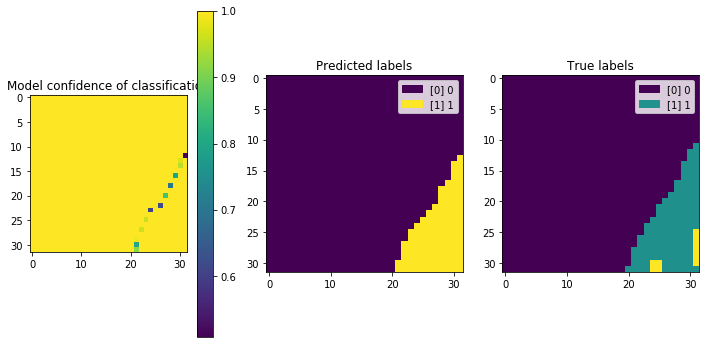

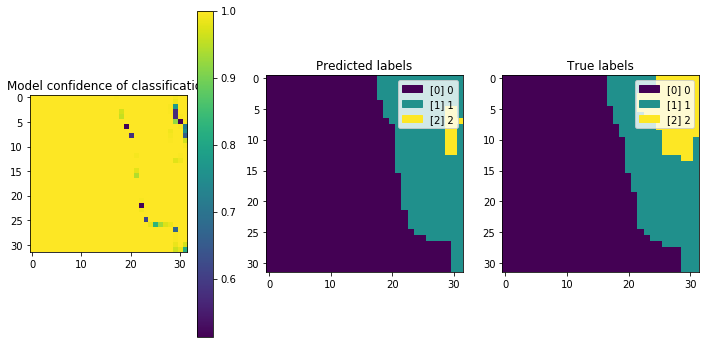

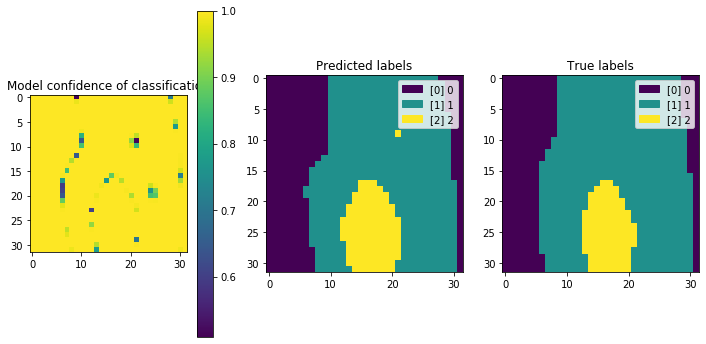

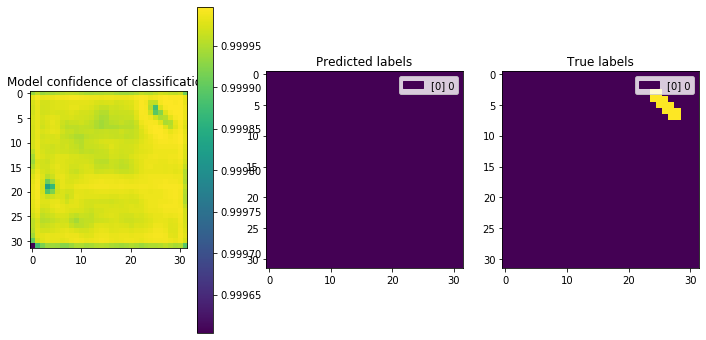

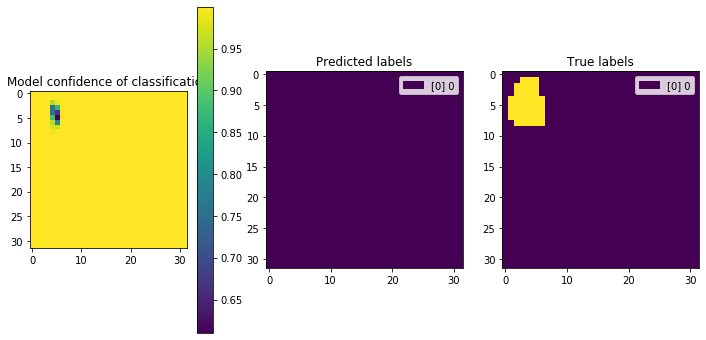

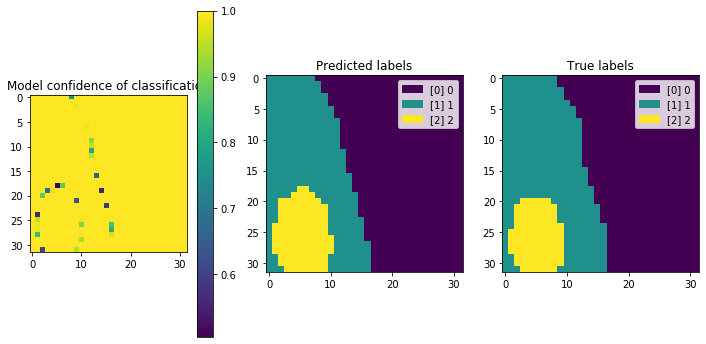

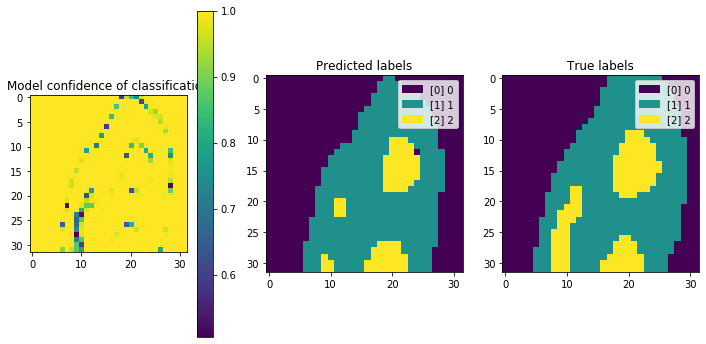

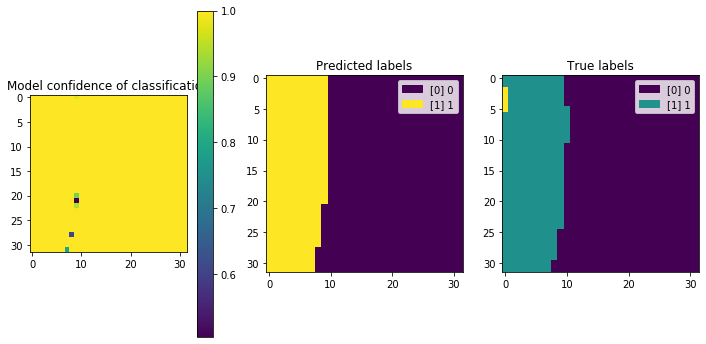

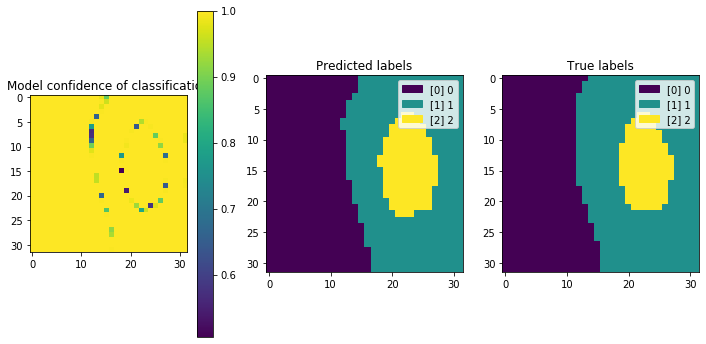

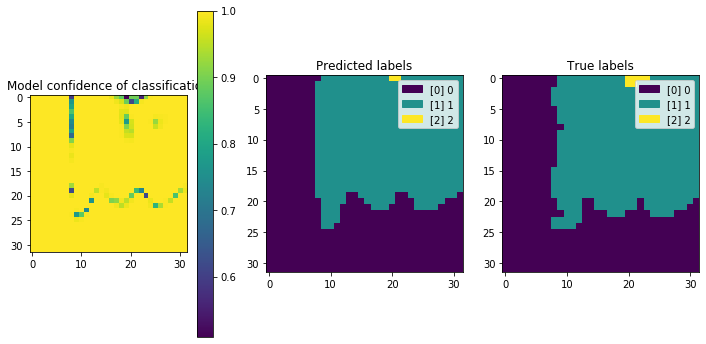

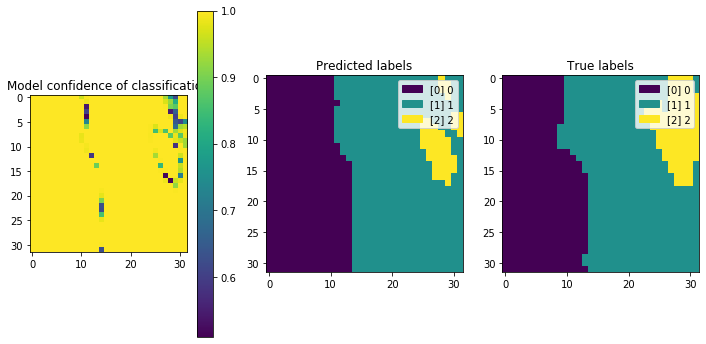

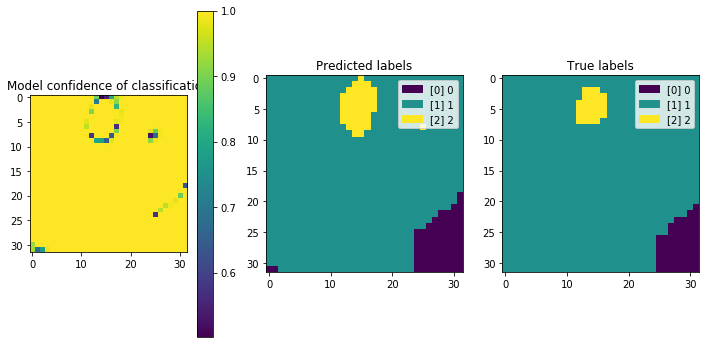

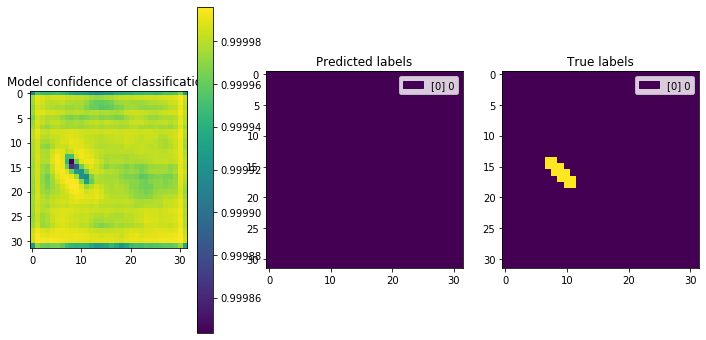

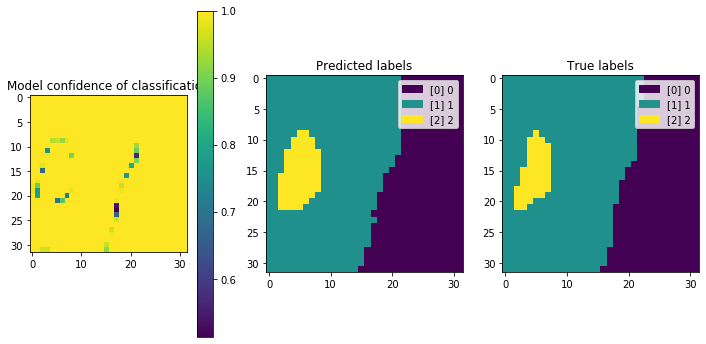

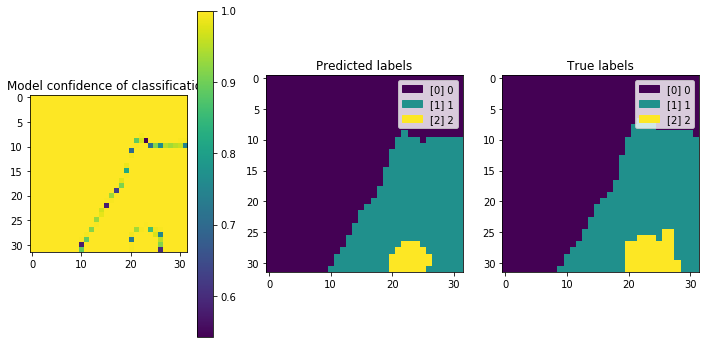

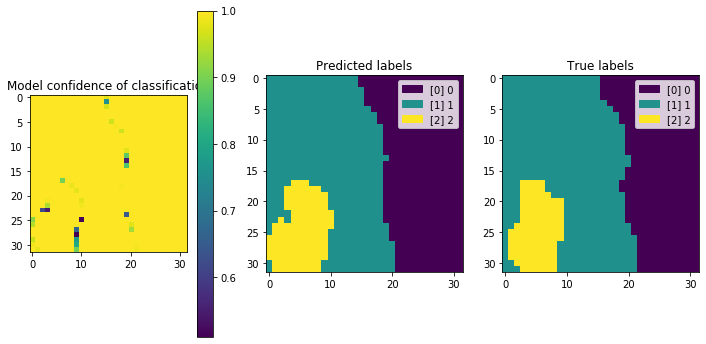

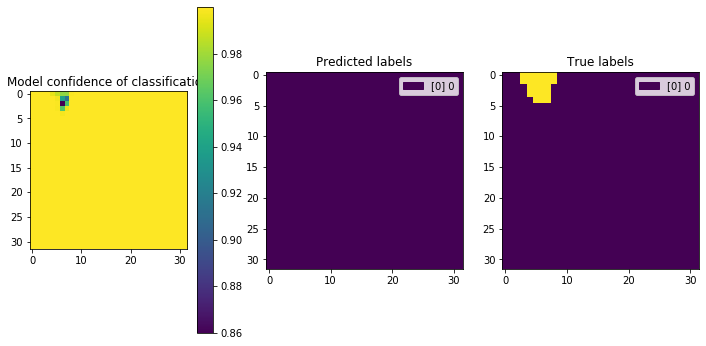

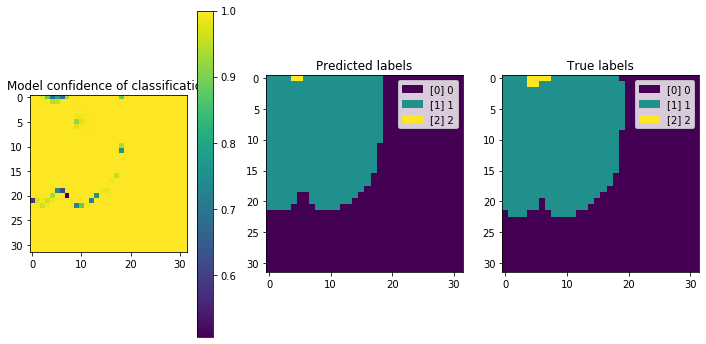

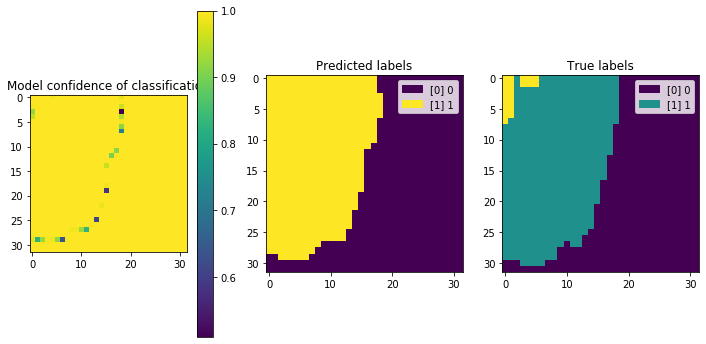

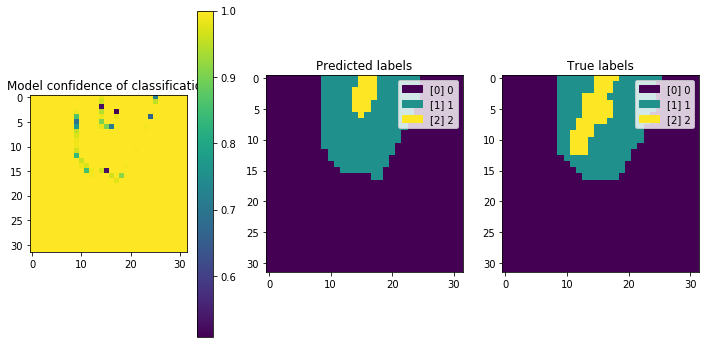

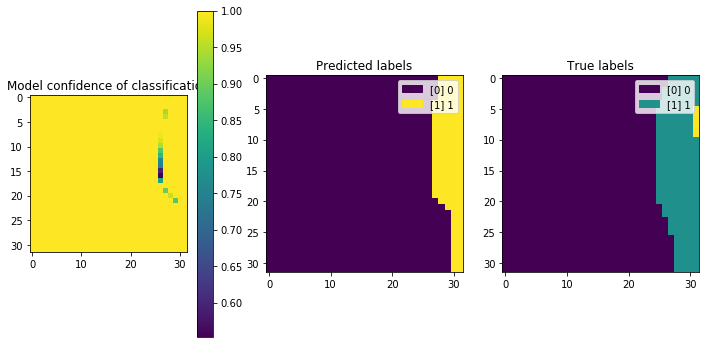

In [17]:
def get_classification_heat_map(y_hat, heat_maps):
    heat = np.zeros(y_hat.shape)
    heat[y_hat == 0] = heat_maps[..., 0][y_hat == 0]
    heat[y_hat == 1] = heat_maps[..., 1][y_hat == 1]
    heat[y_hat == 2] = heat_maps[..., 2][y_hat == 2]
    return heat

def plot_with_heat_map(y_hat, heat_maps, y):
    heat = get_classification_heat_map(y_hat, heat_maps)

    plt.figure(figsize=(12, 6))
    plt.subplot(131)
    plt.imshow(heat)
    plt.colorbar()
    plt.title("Model confidence of classification")
    plt.subplot(132)
    img = plt.imshow(y_hat)
    mypackage.Dataset._Dataset__add_legend_to_image(y_hat, img)
    plt.title("Predicted labels")
    plt.subplot(133)
    img = plt.imshow(np.squeeze(y))
    mypackage.Dataset._Dataset__add_legend_to_image(y_hat, img)
    plt.title("True labels")

# y_pred_test, y_pred_heat = unet.predict(X_test[..., channels_used], Y_labels=Y_test, return_heat_map=True);
np.unique(Y_test)
for i in range(len(Y_test)):
    if 2 in Y_test[i]:
#         plt.figure()
#         plt.imshow(np.squeeze(Y_test[i]))
#         plot_with_heat_map(y_hat, heat_maps, x, y)
        plot_with_heat_map(y_pred_test[i], y_pred_heat[i], Y_test[i])
        


In [30]:
# # https://stackoverflow.com/questions/38009682/how-to-tell-if-tensorflow-is-using-gpu-acceleration-from-inside-python-shell
# import tensorflow as tf
# from tensorflow.python.client import device_lib

# print(device_lib.list_local_devices())
# print("The following list should not be empty")
# print(tf.test.gpu_device_name())
# print("The following should contain stuff, and then be True, True")
# print(tf.config.experimental.list_physical_devices('GPU'), tf.test.is_built_with_cuda(), tf.test.is_gpu_available( cuda_only=False, min_cuda_compute_capability=None))

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 11399390308875687869
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 8121557993757061206
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 9183199080377820849
physical_device_desc: "device: XLA_GPU device"
]
The following list should not be empty

The following should contain stuff, and then be True, True
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
[] True False
